## VM Configuration

In [ ]:
!nvidia-smi

Mon May 19 11:46:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Instalar la biblioteca de información de hardware
!pip install gputil

import GPUtil

# Obtener información sobre la GPU
gpus = GPUtil.getGPUs()

for gpu in gpus:
    print(f"ID: {gpu.id}, Nombre: {gpu.name}, Memoria Libre: {gpu.memoryFree} MB, Memoria Usada: {gpu.memoryUsed} MB, Carga GPU: {gpu.load * 100}%")


  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=b55154d29c573f2123f7898785fa6a63ba8b0e2f8b70affa5871ba2af18c10e4
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built gputil
ID: 0, Nombre: NVIDIA A100-SXM4-40GB, Memoria Libre: 40506.0 MB, Memoria Usada: 0.0 MB, Carga GPU: 0.0%


In [ ]:
import platform
import os

# Obtener información sobre el sistema operativo
print(f"Sistema Operativo: {platform.system()} {platform.version()}")

# Obtener información sobre la arquitectura del sistema
print(f"Arquitectura del Sistema: {platform.architecture()}")

# Obtener información sobre el procesador
print(f"Procesador: {platform.processor()}")

# Obtener información sobre la memoria RAM disponible
print(f"Memoria RAM disponible: {os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES') / (1024. ** 3):.2f} GB")


Sistema Operativo: Linux #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
Arquitectura del Sistema: ('64bit', 'ELF')
Procesador: x86_64
Memoria RAM disponible: 83.48 GB


## Business Understanding

## Data Adquisition & Understanding

In [1]:
!pip install matplotlib-scalebar
!pip install prince
!pip install mapclassify
!pip install libpysal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 23.7 MB/s eta 0:00:00


In [2]:
from google.colab import files
import numpy as np
import pandas as pd
import geopandas as gpd
import pyarrow as pa
import pyarrow.parquet as pq
from IPython.display import display
from libpysal.weights import Queen
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prince import MCA
from datetime import datetime
import calendar
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dropout, MaxPooling1D, Flatten, Dense, GRU, ConvLSTM2D, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from keras.regularizers import l2
from keras.layers import LSTM
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)

Lectura de archivos

In [3]:
# Archivo puntos estaciones metereológicas
em_bgta_2019 = gpd.read_file('EM_BGTA_2019.shp')
# Archivo polígonos UTAM
utam = gpd.read_file('UTAM.shp')
# Archivo polígonos ZAT
zat = gpd.read_file('ZAT.shp')
# Archivo precipitaciones por hora
prec_bgta = pd.read_csv("Precipitacion_Bgta.csv", sep=",", encoding='latin1', parse_dates=["Fecha"])
# Archivo puntos siniestros viales 2019
traffic_acc = gpd.read_file('Siniestros_Viales_2019_Bogota_Urbano.shp')

## 1. Creación de variables que no hacen parte del Dataset original

Se enriqueció el Dataset original UTAM a partir de información extraíble de las fuentes de:

*   **Siniestros_Viales_2019_Bogota_Urbano.shp:** Consolidado de los siniestros viales georreferenciados ocurridos en Bogotá en el año 2019.
*   **EM_BGTA_2019.shp:** Estaciones meteorológicas asignadas a Bogotá.
*   **Precipitacion_Bgta.csv:** Consolidado de la precipitación a nivel de horas capturadas por las Estaciones Metereológicas de Bogotá.

Las variables a crear se dividen en tres (3) tipos:

*   **Type I:** this type of variables are only spatially varied but temporally static during the study period, mainly due to the relatively long time period of data collection.
*   **Type II:** this type of variables are only temporally varied but spatially static during the study period, which refer to weather variables in this study.
*   **Type III:** this type of variables are both spatially and  temporally varied during the study period.

**1.1. Espaciales:** X11: Usos del suelo y X12: Estratificación socioeconómica

Seis (6) Dimensiones explican el 81.2% de la varianza en UTAM

Seis (6) Dimensiones explican el 81.2% de la varianza en ZAT



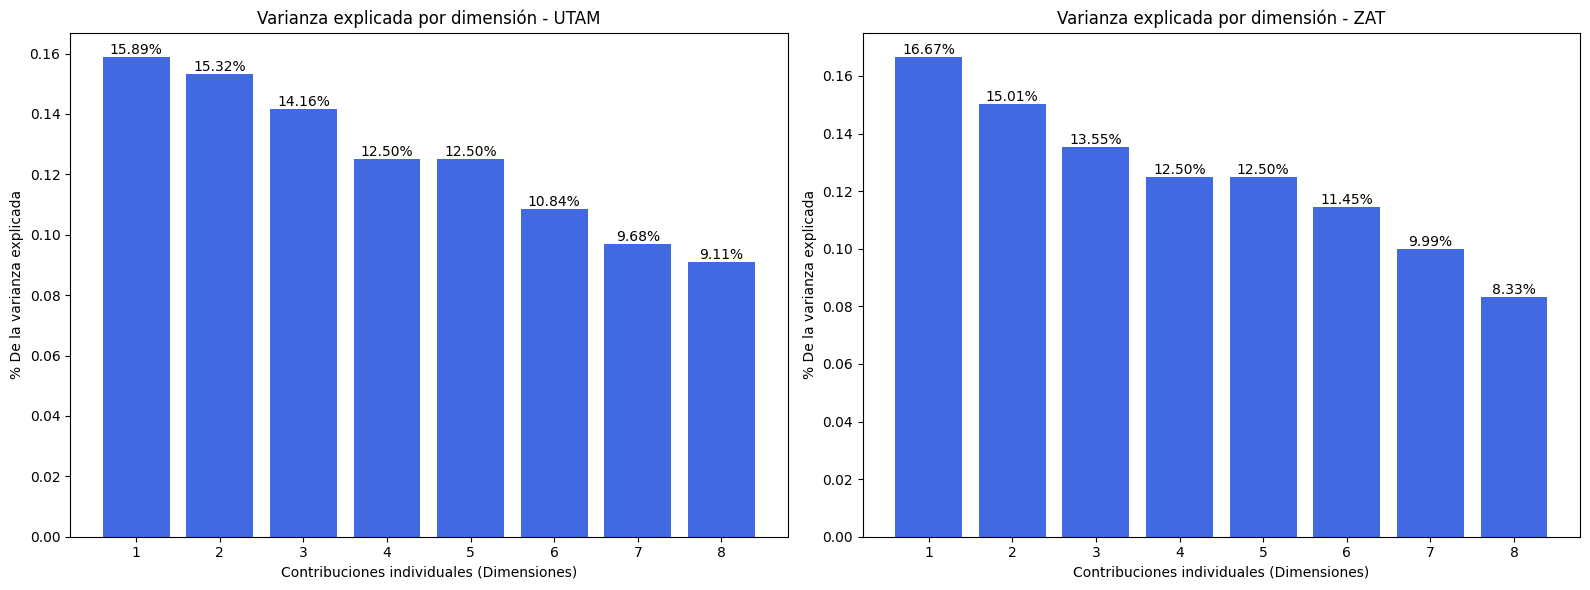

In [4]:
# Calcular analisis de correspondencia de variables categoricas
mca_x11_x12 = MCA(n_components=8, copy=True, check_input=True, engine='sklearn', random_state=42) # UTAM
mca_x11_x12.fit(utam[['X11','X12']])
mca_x11_x12_zat = MCA(n_components=8, copy=True, check_input=True, engine='sklearn', random_state=42) # ZAT
mca_x11_x12_zat.fit(zat[['X11','X12']])
# Obtener los valores propios (eigenvalues)
eigenvalues = mca_x11_x12.eigenvalues_ # UTAM
eigenvalues_zat = mca_x11_x12_zat.eigenvalues_ #ZAT
# Calcular el porcentaje de varianza explicada por cada componente
explained_variance_ratio_utam = eigenvalues / np.sum(eigenvalues) # UTAM
explained_variance_ratio_zat = eigenvalues_zat / np.sum(eigenvalues_zat) # ZAT

# Crear subgráficos uno al lado del otro
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# Graficar varianza explicada por dimensión - UTAM
axs[0].bar(range(1, len(explained_variance_ratio_utam) + 1), explained_variance_ratio_utam, color='royalblue')
axs[0].set_xlabel("Contribuciones individuales (Dimensiones)")
axs[0].set_ylabel("% De la varianza explicada")
axs[0].set_title("Varianza explicada por dimensión - UTAM")
# Agregar etiquetas encima de las barras
for i, explained_variance in enumerate(explained_variance_ratio_utam):
    axs[0].text(i + 1, explained_variance, f"{explained_variance:.2%}", ha='center', va='bottom')
print("Seis (6) Dimensiones explican el 81.2% de la varianza en UTAM\n")

# Graficar varianza explicada por dimensión - ZAT
axs[1].bar(range(1, len(explained_variance_ratio_zat) + 1), explained_variance_ratio_zat, color='royalblue')
axs[1].set_xlabel("Contribuciones individuales (Dimensiones)")
axs[1].set_ylabel("% De la varianza explicada")
axs[1].set_title("Varianza explicada por dimensión - ZAT")
# Agregar etiquetas encima de las barras
for i, explained_variance in enumerate(explained_variance_ratio_zat):
    axs[1].text(i + 1, explained_variance, f"{explained_variance:.2%}", ha='center', va='bottom')
print("Seis (6) Dimensiones explican el 81.2% de la varianza en ZAT\n")

plt.tight_layout()
plt.show()

In [5]:
#UTAM
#Construcción de nueva variable cuantitativa X11_X12 con las contribuciones individuales de las 6 primeras dimensiones
coordinates = mca_x11_x12.row_coordinates(utam[['X11','X12']])
# Calcular X11_X12 con las contribuciones individuales de las seis (6) primeras dimensiones
X11_X12 = np.sum((coordinates.iloc[:,:6] ** 2) * list(explained_variance_ratio_utam[:6]), axis=1) ** 0.5
# Unir al geodataframe original
utam['X11_X12'] = X11_X12

#ZAT
#Construcción de nueva variable cuantitativa X11_X12 con las contribuciones individuales de las 6 primeras dimensiones
coordinates_zat = mca_x11_x12_zat.row_coordinates(zat[['X11','X12']])
# Calcular X11_X12 con las contribuciones individuales de las seis (6) primeras dimensiones
X11_X12 = np.sum((coordinates_zat.iloc[:,:6] ** 2) * list(explained_variance_ratio_zat[:6]), axis=1) ** 0.5
# Unir al geodataframe original
zat['X11_X12'] = X11_X12

In [6]:
utam.head(3)

UTAM   LEN_KM            X1          X2        X3        X4        X5  \
0  UTAM100  44.0923  14736.991820  222.516501  0.095234  0.022932  0.006423   
1   UTAM83  10.4924  23837.039191  155.120864  0.085084  0.023362  0.002770   
2  UTAM107  35.4307  15563.169543  319.899985  0.102909  0.021488  0.009770   

         X6        X7        X8            X9       X10                   X11  \
0  0.012413  0.003794  0.008898  11205.057255  0.193939           RESIDENCIAL   
1  0.008108  0.005857  0.004597   3582.989186  0.029582  COMERCIO Y SERVICIOS   
2  0.026569  0.001471  0.005627   6149.288628  0.084273           RESIDENCIAL   

   X12    X13        X14                                           geometry  \
0    4  14357  38.579399  POLYGON ((1001241.187 1004919.798, 1001168.717...   
1    2   3978  38.963402  POLYGON ((989047.934 1003315.711, 988954.046 1...   
2    4  10092  45.231300  POLYGON ((997980.582 1004293.956, 998018.92 10...   

    X11_X12  
0  0.590481  
1  0.926658  
2  0.590481

**1.2.  Temporales:** X15: Precipitación y X16: Iluminación

Primero se asignaron las estaciones metereológicas más cercanas a cada UTAM

In [7]:
# Centroides utam
utam_cen = gpd.GeoDataFrame(utam.drop('geometry', axis=1),
                            geometry=utam['geometry'].centroid)

# Encontrar la estación meterológica más cercana del centroide de cada UTAM
for idx2, point2 in utam_cen.iterrows():
    nearest_idx = em_bgta_2019.geometry.distance(point2.geometry).idxmin()
    nearest_point = em_bgta_2019.loc[nearest_idx]

    # Asigna la estación meterológica más cercana del centroide de cada UTAM
    #for column in em_bgta_2019.columns:
    for column in em_bgta_2019.columns[1:3]:
        if column != 'geometry':
            utam.at[idx2, column] = nearest_point[column]
            utam_cen.at[idx2, column] = nearest_point[column]


# Centroides zat
zat_cen = gpd.GeoDataFrame(zat.drop('geometry', axis=1),
                            geometry=zat['geometry'].centroid)

# Encontrar la estación meterológica más cercana del centroide de cada UTAM
for idx2, point2 in zat_cen.iterrows():
    nearest_idx = em_bgta_2019.geometry.distance(point2.geometry).idxmin()
    nearest_point = em_bgta_2019.loc[nearest_idx]

    # Asigna la estación meterológica más cercana del centroide de cada UTAM
    #for column in em_bgta_2019.columns:
    for column in em_bgta_2019.columns[1:3]:
        if column != 'geometry':
            zat.at[idx2, column] = nearest_point[column]
            zat_cen.at[idx2, column] = nearest_point[column]

Veamos la asignación

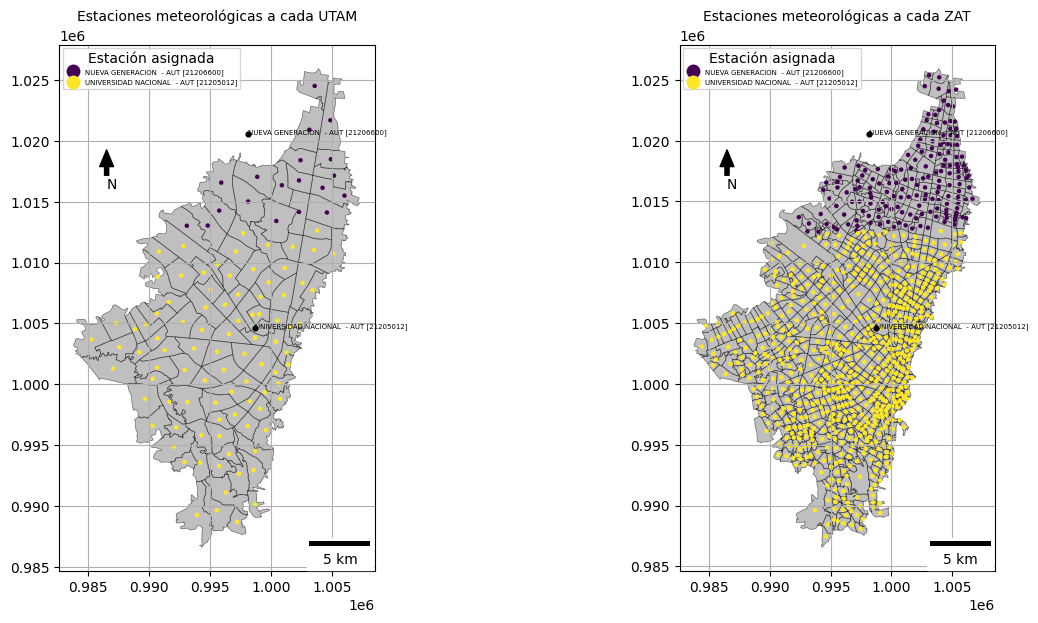

In [8]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6.5))
fig.subplots_adjust(top=0.92, wspace=0.001)  # Adjust spacing between subplots

# Plot for UTAM
ax_utam = axes[0]
ax_utam.set_title('Estaciones meteorológicas a cada UTAM', fontsize=10)
utam.plot(ax=ax_utam, facecolor='grey', edgecolor='black', legend=True, linewidth=0.5, alpha=0.5)
em_bgta_2019.plot(ax=ax_utam, color='black', markersize=12)

for idx, row in em_bgta_2019.iterrows():
    ax_utam.annotate(row['NombreEsta'], (row.geometry.x, row.geometry.y), fontsize=5, ha='left')

utam_cen.plot(ax=ax_utam, column='NombreEsta', legend=True,
              legend_kwds={'title': 'Estación asignada', 'loc': 'upper left', 'fontsize': 5},
              cmap='viridis', markersize=5)

ax_utam.annotate('N', xy=(0.15, 0.8), xytext=(0.15, 0.8 - 0.08),
                 arrowprops=dict(facecolor='black', width=3, headwidth=10),
                 ha='left', va='bottom', fontsize=10, xycoords='axes fraction')
ax_utam.add_artist(ScaleBar(1, location='lower right'))
ax_utam.grid(True)

# Plot for ZAT
ax_zat = axes[1]
ax_zat.set_title('Estaciones meteorológicas a cada ZAT', fontsize=10)
zat.plot(ax=ax_zat, facecolor='grey', edgecolor='black', legend=True, linewidth=0.5, alpha=0.5)
em_bgta_2019.plot(ax=ax_zat, color='black', markersize=12)

for idx, row in em_bgta_2019.iterrows():
    ax_zat.annotate(row['NombreEsta'], (row.geometry.x, row.geometry.y), fontsize=5, ha='left')

zat_cen.plot(ax=ax_zat, column='NombreEsta', legend=True,
              legend_kwds={'title': 'Estación asignada', 'loc': 'upper left', 'fontsize': 5},
              cmap='viridis', markersize=5)

ax_zat.annotate('N', xy=(0.15, 0.8), xytext=(0.15, 0.8 - 0.08),
                arrowprops=dict(facecolor='black', width=3, headwidth=10),
                ha='left', va='bottom', fontsize=10, xycoords='axes fraction')
ax_zat.add_artist(ScaleBar(1, location='lower right'))
ax_zat.grid(True)

plt.show()

Convertir el DataFrame UTAM en una serie temporal discriminada por hora en el 2019

In [9]:
# Función para expandir el dataframe como una serie temporal
def expandir_registros(row):
    # Crea un DataFrame con la fecha y hora
    fecha_inicio = pd.to_datetime("2019-01-01 00:00:00")
    fecha_hora = [fecha_inicio + pd.Timedelta(hours=i) for i in range(8760)]
    # Copia las columnas que deseas mantener constantes del registro original
    df_cols = utam.columns.tolist()
    df = pd.DataFrame(columns=df_cols)
    # Asigna los valores constantes a cada columna del DataFrame
    for col in df_cols:
        df[col] = [row[col]] * 8760
    df['FECHA_HORA'] = fecha_hora
    return df

# Función para expandir el dataframe como una serie temporal
def expandir_registros_zat(row):
    # Crea un DataFrame con la fecha y hora
    fecha_inicio = pd.to_datetime("2019-01-01 00:00:00")
    fecha_hora = [fecha_inicio + pd.Timedelta(hours=i) for i in range(8760)]
    # Copia las columnas que deseas mantener constantes del registro original
    df_cols = zat.columns.tolist()
    df = pd.DataFrame(columns=df_cols)
    # Asigna los valores constantes a cada columna del DataFrame
    for col in df_cols:
        df[col] = [row[col]] * 8760
    df['FECHA_HORA'] = fecha_hora
    return df

In [10]:
# Apliquemos la función para expandir el dataframe como una serie temporal
utam2 = utam.assign(FECHA_HORA=None)
expanded_utam = utam2.apply(expandir_registros, axis=1)
# Concatenar los dataframes
utam_fecha = pd.concat(expanded_utam.to_list(), ignore_index=True)
# ZAT
# Apliquemos la función para expandir el dataframe como una serie temporal
zat2 = zat.assign(FECHA_HORA=None)
expanded_zat = zat2.apply(expandir_registros_zat, axis=1)
# Concatenar los dataframes
zat_fecha = pd.concat(expanded_zat.to_list(), ignore_index=True)

Filtremos la información de precipitación por año 2019

In [11]:
prec_bgta_2019 = prec_bgta[pd.to_datetime(prec_bgta['Fecha']).dt.year == 2019]

In [12]:
# Crear columnas Concatenadas para crear llaves compuestas
utam_fecha['Concatenada'] = utam_fecha['CodigoEsta'].astype('int64').astype(str) + '_' + utam_fecha['FECHA_HORA'].astype(str)
prec_bgta_2019['Concatenada'] = prec_bgta_2019['CodigoEstacion'].astype(str) + '_' + prec_bgta_2019['Fecha'].astype(str)
# Hacer match entre llaves compuestas para obtener el valor de las precipitaciones por fecha
utam_fecha['X15'] = utam_fecha['Concatenada'].map(prec_bgta_2019.set_index('Concatenada')['Valor']) # Variable X15 Precipitación horaria
# Eliminar columnas concatenadas
utam_fecha.drop('Concatenada', axis=1, inplace=True)
prec_bgta_2019.drop('Concatenada', axis=1, inplace=True)

# Crear columnas Concatenadas para crear llaves compuestas
zat_fecha['Concatenada'] = zat_fecha['CodigoEsta'].astype('int64').astype(str) + '_' + zat_fecha['FECHA_HORA'].astype(str)
prec_bgta_2019['Concatenada'] = prec_bgta_2019['CodigoEstacion'].astype(str) + '_' + prec_bgta_2019['Fecha'].astype(str)
# Hacer match entre llaves compuestas para obtener el valor de las precipitaciones por fecha
zat_fecha['X15'] = zat_fecha['Concatenada'].map(prec_bgta_2019.set_index('Concatenada')['Valor']) # Variable X15 Precipitación horaria
# Eliminar columnas concatenadas
zat_fecha.drop('Concatenada', axis=1, inplace=True)
prec_bgta_2019.drop('Concatenada', axis=1, inplace=True)

In [13]:
#utam_fecha[utam_fecha['X15']!=0]
utam_fecha.tail(2)

UTAM  LEN_KM            X1         X2        X3        X4        X5  \
963598  UTAM52  38.773  10578.041875  76.056346  0.080839  0.036895  0.000914   
963599  UTAM52  38.773  10578.041875  76.056346  0.080839  0.036895  0.000914   

              X6        X7   X8  ...          X11  X12   X13     X14  \
963598  0.003559  0.003368  0.0  ...  RESIDENCIAL    1  4984  31.816   
963599  0.003559  0.003368  0.0  ...  RESIDENCIAL    1  4984  31.816   

                                                 geometry   X11_X12  \
963598  POLYGON ((998905.6261999998 991238.8208000008,...  0.687873   
963599  POLYGON ((998905.6261999998 991238.8208000008,...  0.687873   

        CodigoEsta                              NombreEsta  \
963598  21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
963599  21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   

                FECHA_HORA  X15  
963598 2019-12-31 22:00:00  0.0  
963599 2019-12-31 23:00:00  0.0  

[2 rows x 22 columns]

In [14]:
# Calcular variable X16: Iluminación
# Función para clasificar las horas en base a tus condiciones
def clasificar_horas(fecha):
    hora = fecha.hour
    if 6 <= hora < 18:
        return "Optima"
    else:
        return "Limitada"

# Aplicar la función a la columna "Fecha" para crear la columna "X16" UTAM
utam_fecha['X16'] = utam_fecha['FECHA_HORA'].apply(clasificar_horas)
# Aplicar la función a la columna "Fecha" para crear la columna "X16" ZAT
zat_fecha['X16'] = zat_fecha['FECHA_HORA'].apply(clasificar_horas)

In [15]:
utam_fecha.head(3)

UTAM   LEN_KM           X1          X2        X3        X4        X5  \
0  UTAM100  44.0923  14736.99182  222.516501  0.095234  0.022932  0.006423   
1  UTAM100  44.0923  14736.99182  222.516501  0.095234  0.022932  0.006423   
2  UTAM100  44.0923  14736.99182  222.516501  0.095234  0.022932  0.006423   

         X6        X7        X8  ...  X12    X13        X14  \
0  0.012413  0.003794  0.008898  ...    4  14357  38.579399   
1  0.012413  0.003794  0.008898  ...    4  14357  38.579399   
2  0.012413  0.003794  0.008898  ...    4  14357  38.579399   

                                            geometry   X11_X12  CodigoEsta  \
0  POLYGON ((1001241.1869999999 1004919.798299999...  0.590481  21205012.0   
1  POLYGON ((1001241.1869999999 1004919.798299999...  0.590481  21205012.0   
2  POLYGON ((1001241.1869999999 1004919.798299999...  0.590481  21205012.0   

                               NombreEsta          FECHA_HORA  X15       X16  
0  UNIVERSIDAD NACIONAL  - AUT [21205012] 2019-01-01 00:00:00  0.0  Limitada  
1  UNIVERSIDAD NACIONAL  - AUT [21205012] 2019-01-01 01:00:00  0.0  Limitada  
2  UNIVERSIDAD NACIONAL  - AUT [21205012] 2019-01-01 02:00:00  0.0  Limitada  

[3 rows x 23 columns]

**1.3.  Espacio temporales:** TC_COUNTS: Accidentes por HORA/UTAM

Calcular variable TC_COUNTS (Conteos por UTAM)

In [16]:
# -----------------------------------UTAM-----------------------------------
utam_tracc = gpd.sjoin(traffic_acc, utam, how='inner', predicate='intersects')
# Convertir fecha a formato YYYY/MM/DD HH:MM:SS y redondear las fechas a MM:SS = 0
utam_tracc['FECHA_HORAS'] = pd.to_datetime(utam_tracc['FECHA_H'], format='%d/%m/%Y %H:%M:%S').dt.strftime('%Y/%m/%d %H:%M:%S').apply(pd.to_datetime).dt.floor('H')
# Contar # accidentes por hora/utam
utam_tracc_hours = utam_tracc.groupby(['UTAM', utam_tracc['FECHA_HORAS']]).size().reset_index(name='Conteo')
# Crear columnas Concatenadas para crear llaves compuestas
utam_fecha['Concatenada'] = utam_fecha['UTAM'] + '_' + utam_fecha['FECHA_HORA'].astype(str)
utam_tracc_hours['Concatenada'] = utam_tracc_hours['UTAM'] + '_' + utam_tracc_hours['FECHA_HORAS'].astype(str)
# Hacer match entre llaves compuestas para obtener el valor de las precipitaciones por fecha
utam_fecha['TC_COUNTS'] = utam_fecha['Concatenada'].map(utam_tracc_hours.set_index('Concatenada')['Conteo']) # Variable Y Conteo por UTAM/HORA
# Eliminar columnas concatenadas
utam_fecha.drop('Concatenada', axis=1, inplace=True)
# -----------------------------------ZAT-----------------------------------
zat_tracc = gpd.sjoin(traffic_acc, zat, how='inner', predicate='intersects')
# Convertir fecha a formato YYYY/MM/DD HH:MM:SS y redondear las fechas a MM:SS = 0
zat_tracc['FECHA_HORAS'] = pd.to_datetime(zat_tracc['FECHA_H'], format='%d/%m/%Y %H:%M:%S').dt.strftime('%Y/%m/%d %H:%M:%S').apply(pd.to_datetime).dt.floor('H')
# Contar # accidentes por hora/utam
zat_tracc_hours = zat_tracc.groupby(['ZAT_', zat_tracc['FECHA_HORAS']]).size().reset_index(name='Conteo')
# Crear columnas Concatenadas para crear llaves compuestas
zat_fecha['Concatenada'] = zat_fecha['ZAT_'] + '_' + zat_fecha['FECHA_HORA'].astype(str)
zat_tracc_hours['Concatenada'] = zat_tracc_hours['ZAT_'] + '_' + zat_tracc_hours['FECHA_HORAS'].astype(str)
# Hacer match entre llaves compuestas para obtener el valor de las precipitaciones por fecha
zat_fecha['TC_COUNTS'] = zat_fecha['Concatenada'].map(zat_tracc_hours.set_index('Concatenada')['Conteo']) # Variable Y Conteo por UTAM/HORA
# Eliminar columnas concatenadas
zat_fecha.drop('Concatenada', axis=1, inplace=True)

In [17]:
utam_fecha['TC_COUNTS'] = utam_fecha['TC_COUNTS'].fillna(0) # Reemplazar valores NaN por 0 (no hay accidentes)
zat_fecha['TC_COUNTS'] = zat_fecha['TC_COUNTS'].fillna(0) # Reemplazar valores NaN por 0 (no hay accidentes)

In [18]:
utam_fecha.head(3)

UTAM   LEN_KM           X1          X2        X3        X4        X5  \
0  UTAM100  44.0923  14736.99182  222.516501  0.095234  0.022932  0.006423   
1  UTAM100  44.0923  14736.99182  222.516501  0.095234  0.022932  0.006423   
2  UTAM100  44.0923  14736.99182  222.516501  0.095234  0.022932  0.006423   

         X6        X7        X8  ...    X13        X14  \
0  0.012413  0.003794  0.008898  ...  14357  38.579399   
1  0.012413  0.003794  0.008898  ...  14357  38.579399   
2  0.012413  0.003794  0.008898  ...  14357  38.579399   

                                            geometry   X11_X12  CodigoEsta  \
0  POLYGON ((1001241.1869999999 1004919.798299999...  0.590481  21205012.0   
1  POLYGON ((1001241.1869999999 1004919.798299999...  0.590481  21205012.0   
2  POLYGON ((1001241.1869999999 1004919.798299999...  0.590481  21205012.0   

                               NombreEsta          FECHA_HORA  X15       X16  \
0  UNIVERSIDAD NACIONAL  - AUT [21205012] 2019-01-01 00:00:00  0.0  Limitada   
1  UNIVERSIDAD NACIONAL  - AUT [21205012] 2019-01-01 01:00:00  0.0  Limitada   
2  UNIVERSIDAD NACIONAL  - AUT [21205012] 2019-01-01 02:00:00  0.0  Limitada   

  TC_COUNTS  
0       0.0  
1       0.0  
2       1.0  

[3 rows x 24 columns]

Miremos el comportamiento de los accidentes de tránsito en la serie temporal

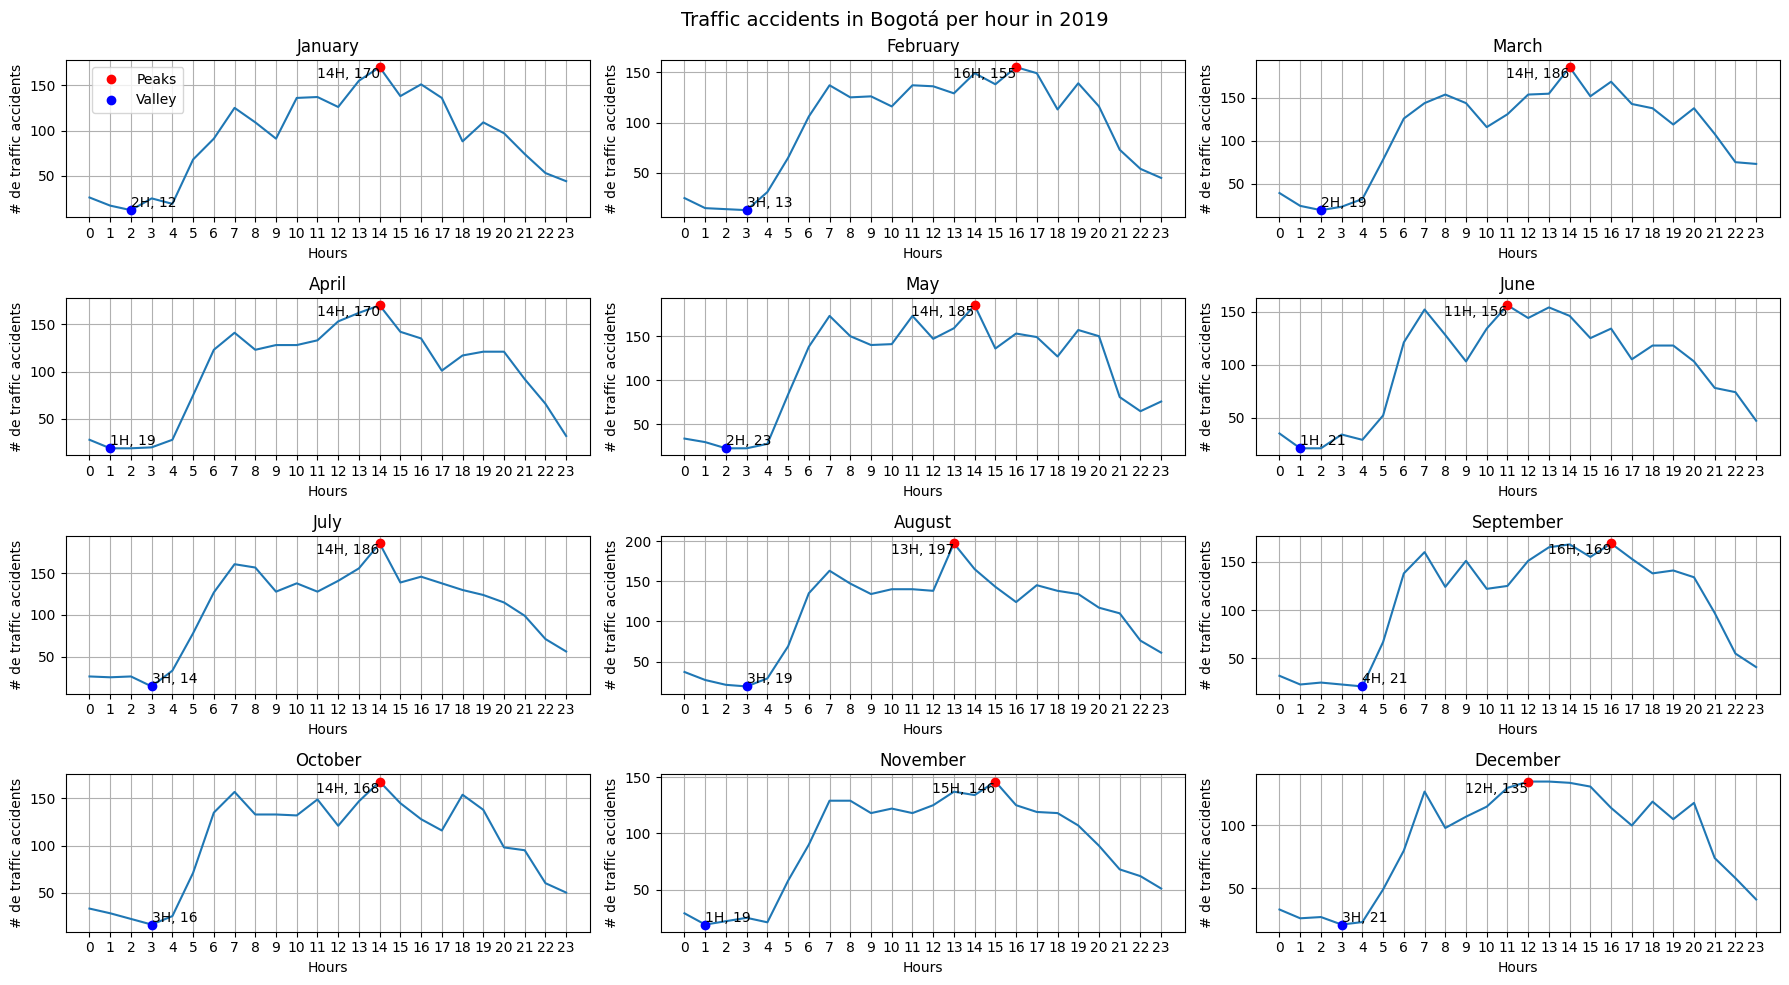

In [19]:
# Figura con una matriz de 4x3 subplots
fig, axs = plt.subplots(4, 3, figsize=(18, 10), sharey=False)
fig.suptitle('Traffic accidents in Bogotá per hour in 2019', fontsize=14)

# Lista para almacenar los artistas de leyenda
legend_artists = []

# Crear un diccionario que mapea los nombres de los meses a sus números correspondientes
meses_dict = {v: k for k, v in enumerate(calendar.month_name[1:], start=1)}

# Subplots para cada mes
for mes, ax in zip(calendar.month_name[1:], axs.flat):
    # Filtrar el DataFrame para el mes actual
    mes_num = meses_dict[mes]
    df_mes = utam_fecha[utam_fecha['FECHA_HORA'].dt.month == mes_num]
    # Agrupar los valores por hora y calcular la suma de los valores
    df_hora = df_mes.groupby(df_mes['FECHA_HORA'].dt.hour)['TC_COUNTS'].sum()
    # Generar la gráfica de línea para el mes
    ax.plot(df_hora.index, df_hora)  # Usar las horas en el eje X
    ax.set_title(mes)  # Utilizar el nombre del mes
    ax.set_xlabel('Hours')
    ax.set_ylabel('# de traffic accidents')
    ax.grid(True)
    ax.set_xticks(range(24))  # Mostrar todas las horas en el eje X

    # Encontrar la hora con el máximo número de accidentes
    max_hour = df_hora.idxmax()
    max_accidents = df_hora.max()

    # Encontrar la hora con el mínimo número de accidentes
    min_hour = df_hora.idxmin()
    min_accidents = df_hora.min()

    # Marcar el máximo con un punto rojo
    ax.plot(max_hour, max_accidents, 'ro', label="Peaks")
    # Marcar el mínimo con un punto azul
    ax.plot(min_hour, min_accidents, 'bo', label="Valley")
    # Anotar el máximo y el mínimo en la gráfica
    ax.annotate(f"{max_hour}H, {int(max_accidents)}", (max_hour, max_accidents), fontsize=10, ha='right', va='top')
    ax.annotate(f"{min_hour}H, {int(min_accidents)}", (min_hour, min_accidents), fontsize=10, ha='left', va='bottom')

    # Agregar los artistas de leyenda de este subplot
    handles, labels = ax.get_legend_handles_labels()
    legend_artists.extend(handles)

# Agregar una leyenda global fuera de los subplots
fig.legend(legend_artists, labels, loc='upper left', bbox_to_anchor=(0.05, 0.93))

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.subplots_adjust(top=0.93)
# Mostrar los subplots
plt.show()


Visualicemos los accidentes por hora en el 2019

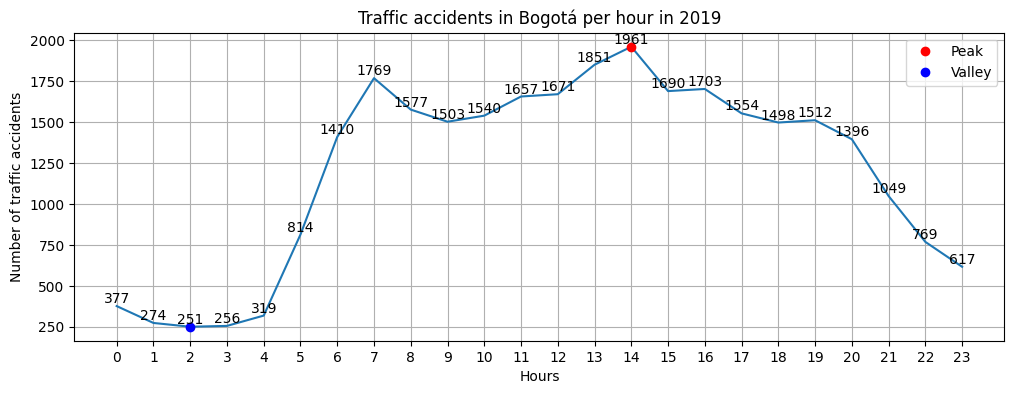

In [20]:
# Agrupar los valores por hora y calcular la suma de los valores
df_hora = utam_fecha.groupby(utam_fecha['FECHA_HORA'].dt.hour)['TC_COUNTS'].sum()

# Crear una gráfica de línea para mostrar los accidentes por hora en todo el año
plt.figure(figsize=(12, 4))
plt.plot(df_hora.index, df_hora)
plt.title('Traffic accidents in Bogotá per hour in 2019')
plt.xlabel('Hours')
plt.ylabel('Number of traffic accidents')
plt.grid(True)
plt.xticks(range(24))  # Mostrar todas las horas en el eje X

# Etiquetar cada punto de la gráfica con el número de accidentes
for hour, accidents in zip(df_hora.index, df_hora):
    plt.annotate(f"{int(accidents)}", (hour, accidents), fontsize=10, ha='center', va='bottom')

# Encontrar la hora con el máximo número de accidentes
max_hour = df_hora.idxmax()
max_accidents = df_hora.max()

# Encontrar la hora con el mínimo número de accidentes
min_hour = df_hora.idxmin()
min_accidents = df_hora.min()

# Marcar el máximo con un punto rojo
plt.plot(max_hour, max_accidents, 'ro', label="Peak")
# Marcar el mínimo con un punto azul
plt.plot(min_hour, min_accidents, 'bo', label="Valley")

# Agregar una leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

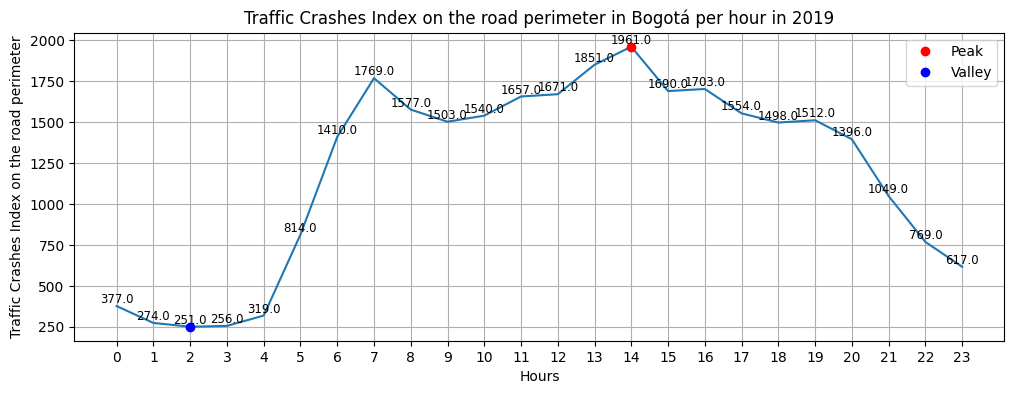

In [21]:
# Agrupar los valores por hora y calcular la suma de los valores
df_hora = utam_fecha.groupby(utam_fecha['FECHA_HORA'].dt.hour)['TC_COUNTS'].sum()

# Crear una gráfica de línea para mostrar los accidentes por hora en todo el año
plt.figure(figsize=(12, 4))
plt.plot(df_hora.index, df_hora)
plt.title('Traffic Crashes Index on the road perimeter in Bogotá per hour in 2019')
plt.xlabel('Hours')
plt.ylabel('Traffic Crashes Index on the road perimeter')
plt.grid(True)
plt.xticks(range(24))  # Mostrar todas las horas en el eje X

# Etiquetar cada punto de la gráfica con el número de accidentes
for hour, accidents in zip(df_hora.index, df_hora):
    plt.annotate(round(accidents,1), (hour, accidents), fontsize=8.5, ha='center', va='bottom')

# Encontrar la hora con el máximo número de accidentes
max_hour = df_hora.idxmax()
max_accidents = df_hora.max()

# Encontrar la hora con el mínimo número de accidentes
min_hour = df_hora.idxmin()
min_accidents = df_hora.min()

# Marcar el máximo con un punto rojo
plt.plot(max_hour, max_accidents, 'ro', label="Peak")
# Marcar el mínimo con un punto azul
plt.plot(min_hour, min_accidents, 'bo', label="Valley")

# Agregar una leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

Calcular variable TCIRP (Traffic Crashes Index on the road perimeter)

In [22]:
utam_fecha['TC_I_UTAM'] = (utam_fecha['TC_COUNTS']/utam_fecha['LEN_KM']) # UTAM
zat_fecha['TC_I_ZAT'] = (zat_fecha['TC_COUNTS']/zat_fecha['LEN_KM']) # ZAT

Visualicemos la distribución espacial de las variables respuesta Conteos vs TC_I_UTAM en el 2019

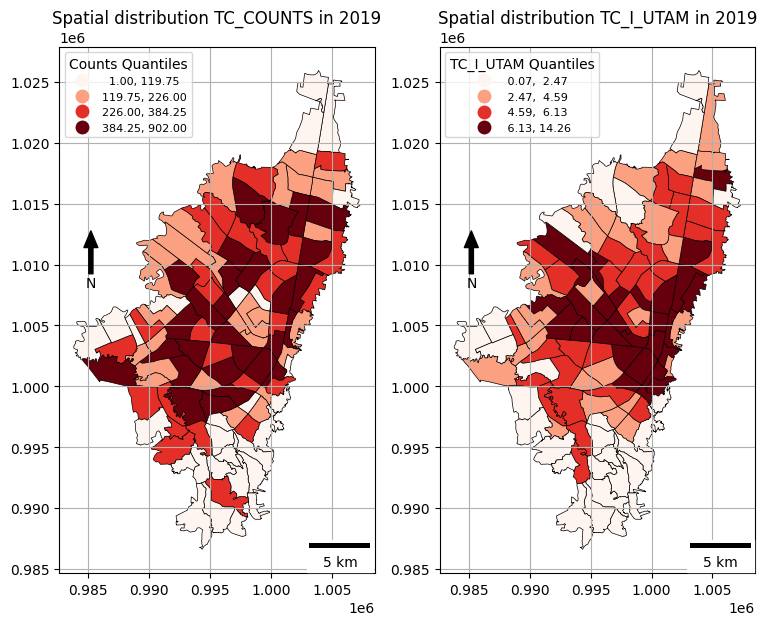

In [23]:
## Agrupemos y recuperemos la geometría para poder mapear
utam_2019 = utam_fecha.groupby('UTAM')[['TC_COUNTS', 'TC_I_UTAM']].sum().reset_index()
utam_2019 = utam_2019.merge(utam[['UTAM', 'geometry']], on='UTAM', how='inner')
utam_2019 = gpd.GeoDataFrame(utam_2019, geometry='geometry')

zat_2019 = zat_fecha.groupby('ZAT_')[['TC_COUNTS', 'TC_I_ZAT']].sum().reset_index()
zat_2019 = zat_2019.merge(zat[['ZAT_', 'geometry']], on='ZAT_', how='inner')
zat_2019 = gpd.GeoDataFrame(zat_2019, geometry='geometry')

# Configurar la figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6.5))
fig.subplots_adjust(top=0.92)  # Ajusta el valor de wspace según tus preferencias


# Subplot 1: Mapa coroplético para COUNTS (Conteos)
divider = make_axes_locatable(ax1)
utam_2019.plot(column='TC_COUNTS', scheme='Quantiles', k=4, cmap='Reds', linewidth=0.5, edgecolor='black',
               legend=True, ax=ax1,legend_kwds={'title': 'Counts Quantiles','loc': 'upper left','fontsize':8})
ax1.set_title('Spatial distribution TC_COUNTS in 2019', fontsize=12)

# Subplot 2: Mapa coroplético para TC_I_UTAM
divider = make_axes_locatable(ax2)
utam_2019.plot(column='TC_I_UTAM', scheme='Quantiles', k=4, cmap='Reds', linewidth=0.5, edgecolor='black',
               legend=True, ax=ax2,legend_kwds={'title': 'TC_I_UTAM Quantiles','loc': 'upper left','fontsize':8})
ax2.set_title('Spatial distribution TC_I_UTAM in 2019', fontsize=12)

# Agregar norte y escala al primer subplot
x, y, arrow_length = 0.1, 0.65, 0.1
ax1.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=10),
            ha='center', va='center', fontsize=10,
            xycoords=ax1.transAxes)
ax1.add_artist(ScaleBar(1, location='lower right'))
ax1.grid(True)

# Agregar norte y escala al segundo subplot
x, y, arrow_length = 0.1, 0.65, 0.1
ax2.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=10),
            ha='center', va='center', fontsize=10,
            xycoords=ax2.transAxes)
ax2.add_artist(ScaleBar(1, location='lower right'))
ax2.grid(True)

# Mostrar la figura con ambos subplots
plt.show()

Exporte de los archivos a Shapefile

In [24]:
#utam_2019.to_file('UTAM_TCIRP.shp', driver='ESRI Shapefile')
#zat_2019.to_file('ZAT_TCIRP.shp', driver='ESRI Shapefile')

Ahora miremos su compartamiento a nivel horario del TCIRP en UTAM

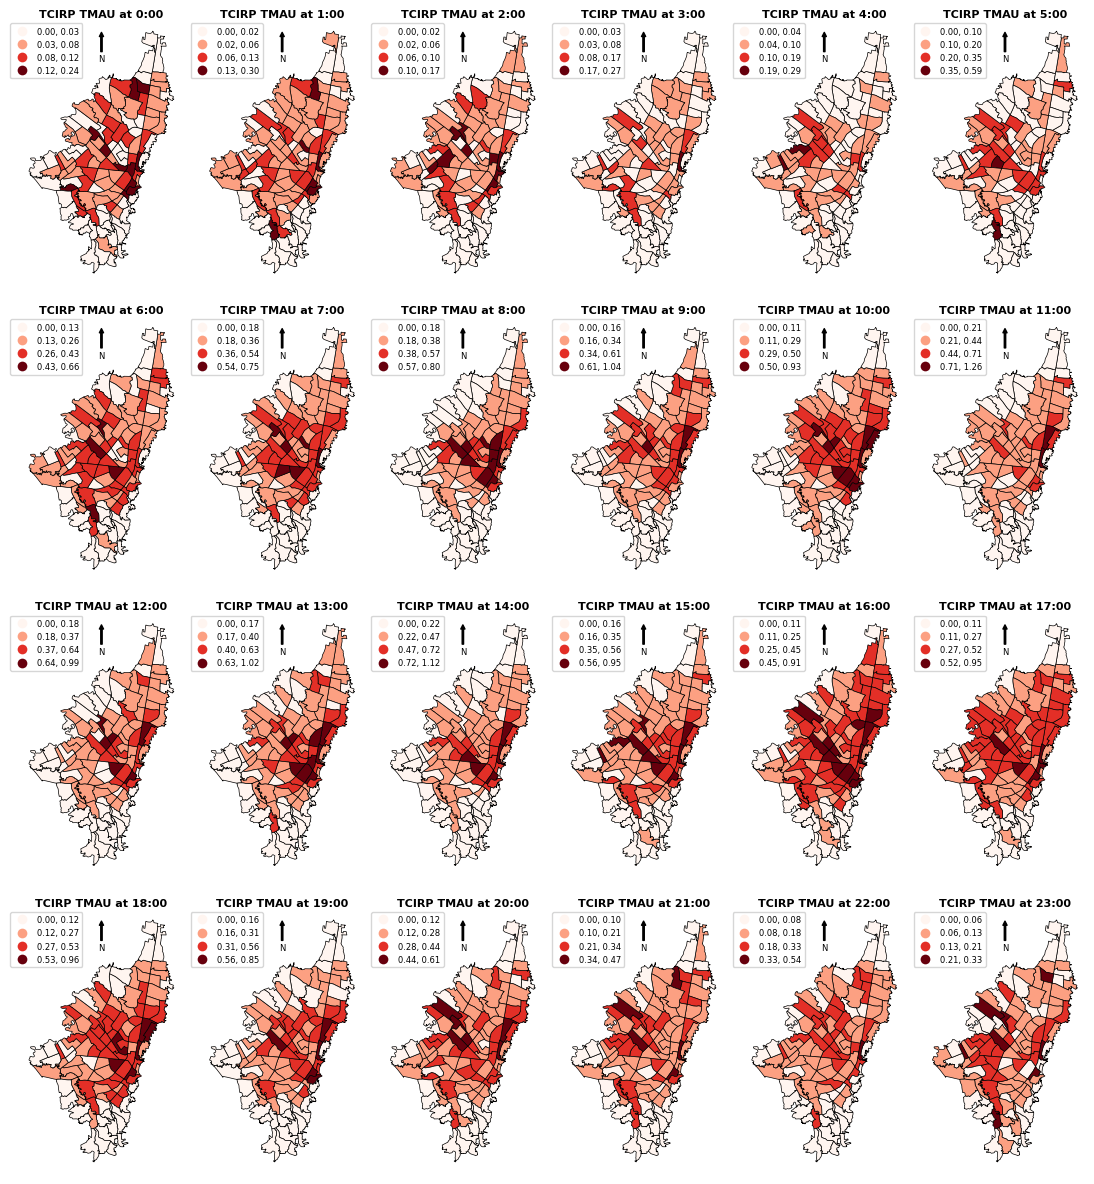

In [25]:
# Extrae la hora como 'H' en una nueva columna
utam_fecha['H'] = utam_fecha['FECHA_HORA'].dt.hour
utam_2019_h = utam_fecha.groupby(['UTAM','H'])[['TC_I_UTAM']].sum().reset_index()
utam_2019_h = utam_2019_h.merge(utam[['UTAM', 'geometry']], on='UTAM', how='inner')
utam_2019_h = gpd.GeoDataFrame(utam_2019_h, geometry='geometry')

# Define el número de filas y columnas para la matriz de subplots
n_rows = 4
n_cols = 6

# Crea una figura con subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(11, 12))

# Itera a través de las horas para crear los mapas coropléticos
for hour in range(24):
    # Calcula la posición en la matriz de subplots
    row = (hour) // n_cols
    col = (hour) % n_cols

    # Filtra los datos para la hora específica
    data_hour_utam = utam_2019_h[utam_2019_h['H'] == hour]

    # Mapa coroplético para la variable 'TC_I_UTAM'
    data_hour_utam.plot(column='TC_I_UTAM', scheme='NaturalBreaks', k=4, cmap='Reds', linewidth=0.5, ax=axs[row, col], edgecolor='black', legend=True, legend_kwds={'loc': 'upper left', 'fontsize': 6, 'markerscale': 0.7,'bbox_to_anchor': (-0.1, 1)})
    axs[row, col].set_title(f'TCIRP TMAU at {hour}:00', fontsize=8, fontweight='bold', pad=-5)
    axs[row, col].axis('off')

    # Agregar norte y escala
    x, y, arrow_length = 0.5, 0.95, 0.1
    axs[row, col].annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
              arrowprops=dict(facecolor='black', width=1, headwidth=3,  headlength=3, shrink=0.001),
              ha='center', va='center', fontsize=6,
              xycoords=axs[row, col].transAxes)

# Ajusta la disposición de los subplots
plt.tight_layout()
# Muestra la figura
plt.show()

Ahora miremos su compartamiento a nivel horario del TCIRP en ZAT

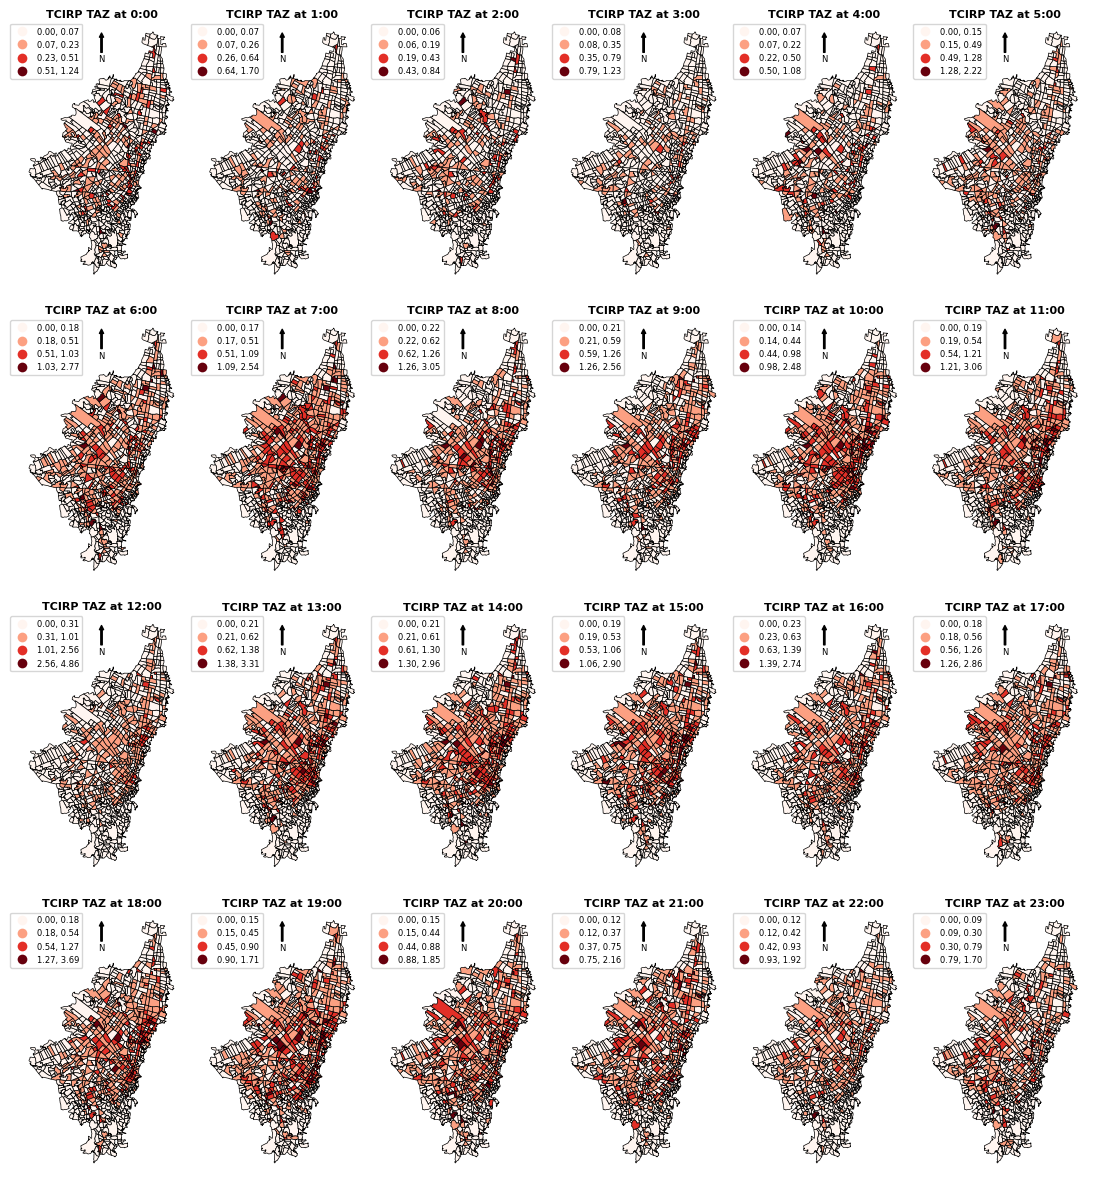

In [26]:
# Extrae la hora como 'H' en una nueva columna
zat_fecha['H'] = zat_fecha['FECHA_HORA'].dt.hour
zat_2019_h = zat_fecha.groupby(['ZAT_','H'])[['TC_I_ZAT']].sum().reset_index()
zat_2019_h = zat_2019_h.merge(zat[['ZAT_', 'geometry']], on='ZAT_', how='inner')
zat_2019_h = gpd.GeoDataFrame(zat_2019_h, geometry='geometry')

# Define el número de filas y columnas para la matriz de subplots
n_rows = 4
n_cols = 6

# Crea una figura con subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(11, 12))

# Itera a través de las horas para crear los mapas coropléticos
for hour in range(24):
    # Calcula la posición en la matriz de subplots
    row = (hour) // n_cols
    col = (hour) % n_cols

    # Filtra los datos para la hora específica
    data_hour_zat = zat_2019_h[zat_2019_h['H'] == hour]

    # Mapa coroplético para la variable 'TC_I_ZAT'
    data_hour_zat.plot(column='TC_I_ZAT', scheme='NaturalBreaks', k=4, cmap='Reds', linewidth=0.5, ax=axs[row, col], edgecolor='black', legend=True, legend_kwds={'loc': 'upper left', 'fontsize': 6, 'markerscale': 0.7,'bbox_to_anchor': (-0.1, 1)})
    axs[row, col].set_title(f'TCIRP TAZ at {hour}:00', fontsize=8, fontweight='bold', pad=-5)
    axs[row, col].axis('off')

    # Agregar norte y escala
    x, y, arrow_length = 0.5, 0.95, 0.1
    axs[row, col].annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
              arrowprops=dict(facecolor='black', width=1, headwidth=3,  headlength=3, shrink=0.001),
              ha='center', va='center', fontsize=6,
              xycoords=axs[row, col].transAxes)

# Ajusta la disposición de los subplots
plt.tight_layout()
# Muestra la figura
plt.show()

In [27]:
utam_fecha_or = utam_fecha.sort_values(by='FECHA_HORA')
zat_fecha_or = zat_fecha.sort_values(by='FECHA_HORA')
utam_fecha_or = utam_fecha_or.reset_index(drop=True)
zat_fecha_or = zat_fecha_or.reset_index(drop=True)
utam_fecha_or

UTAM   LEN_KM            X1          X2        X3        X4  \
0       UTAM100  44.0923  14736.991820  222.516501  0.095234  0.022932   
1        UTAM41  71.3475  21443.264937  204.317038  0.080556  0.019538   
2       UTAM103  13.4552    883.891600  394.528286  0.100691  0.022951   
3        UTAM38  71.5699  16954.558692  212.347013  0.079168  0.017086   
4        UTAM35  31.0039  18781.777556  257.831660  0.086433  0.023539   
...         ...      ...           ...         ...       ...       ...   
963595   UTAM98  93.0442  10502.970566  222.454943  0.086938  0.021667   
963596   UTAM96  45.6211  25338.310784  111.264247  0.082927  0.023899   
963597   UTAM92  17.2898  13022.086368  299.056369  0.088359  0.017903   
963598   UTAM36  42.3352  23224.753324  201.071918  0.089725  0.027654   
963599   UTAM52  38.7730  10578.041875   76.056346  0.080839  0.036895   

              X5        X6        X7        X8  ...  \
0       0.006423  0.012413  0.003794  0.008898  ...   
1       0.004566  0.012252  0.003930  0.006236  ...   
2       0.008069  0.031398  0.002320  0.008209  ...   
3       0.004188  0.013893  0.002419  0.003074  ...   
4       0.004227  0.012332  0.004752  0.003910  ...   
...          ...       ...       ...       ...  ...   
963595  0.005974  0.011185  0.003223  0.004427  ...   
963596  0.001542  0.003699  0.004094  0.001035  ...   
963597  0.009659  0.009555  0.002041  0.001652  ...   
963598  0.004779  0.011249  0.003380  0.002772  ...   
963599  0.000914  0.003559  0.003368  0.000000  ...   

                                                 geometry   X11_X12  \
0       POLYGON ((1001241.1869999999 1004919.798299999...  0.590481   
1       POLYGON ((994673.1924999999 999678.6260000002,...  0.294321   
2       POLYGON ((999911.2041999996 1006182.4759999998...  0.885774   
3       POLYGON ((997146.8815000001 999831.6360999998,...  0.294321   
4       POLYGON ((998107.7676999997 997747.0669, 99810...  0.294321   
...                                                   ...       ...   
963595  POLYGON ((1001733.6963999998 1007002.439500000...  0.294321   
963596  POLYGON ((1001368.8294000002 1000117.368799999...  0.396211   
963597  POLYGON ((1001736.1915999996 1002348.063100000...  0.687873   
963598  POLYGON ((998105.2885999996 997743.7841999996,...  0.294321   
963599  POLYGON ((998905.6261999998 991238.8208000008,...  0.687873   

        CodigoEsta                              NombreEsta  \
0       21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
1       21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
2       21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
3       21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
4       21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
...            ...                                     ...   
963595  21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
963596  21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
963597  21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
963598  21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
963599  21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   

                FECHA_HORA  X15       X16  TC_COUNTS  TC_I_UTAM   H  
0      2019-01-01 00:00:00  0.0  Limitada        0.0        0.0   0  
1      2019-01-01 00:00:00  0.0  Limitada        0.0        0.0   0  
2      2019-01-01 00:00:00  0.0  Limitada        0.0        0.0   0  
3      2019-01-01 00:00:00  0.0  Limitada        0.0        0.0   0  
4      2019-01-01 00:00:00  0.0  Limitada        0.0        0.0   0  
...                    ...  ...       ...        ...        ...  ..  
963595 2019-12-31 23:00:00  0.0  Limitada        0.0        0.0  23  
963596 2019-12-31 23:00:00  0.0  Limitada        0.0        0.0  23  
963597 2019-12-31 23:00:00  0.0  Limitada        0.0        0.0  23  
963598 2019-12-31 23:00:00  0.0  Limitada        0.0        0.0  23  
963599 2019-12-31 23:00:00  0.0  Limitada        0.0        0.0  23  

[963600 rows x 26 colu

Revisemos las estadísticas descriptivas

In [28]:
col = (['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11_X12','X13','X14','X15','TC_I_UTAM'])
col_zat = (['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11_X12','X13','X14','X15','TC_I_ZAT'])
utam_des = utam_fecha[col]
zat_des = zat_fecha[col_zat]
utam_des.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11_X12',
       'X13', 'X14', 'X15', 'TC_I_UTAM'],
      dtype='object')

In [29]:
def calcular_estadisticas(dataframe):
    estadisticas = pd.DataFrame()
    for columna in dataframe.columns:
        estadisticas.loc[columna, 'Media'] = dataframe[columna].mean()
        estadisticas.loc[columna, 'Mediana'] = dataframe[columna].median()
        estadisticas.loc[columna, 'Desviación Estándar'] = dataframe[columna].std()
        estadisticas.loc[columna, 'Mínimo'] = dataframe[columna].min()
        estadisticas.loc[columna, 'Máximo'] = dataframe[columna].max()
        estadisticas.loc[columna, 'Kurtosis'] = dataframe[columna].kurtosis()
        estadisticas.loc[columna, 'Asimetría (Skewness)'] = dataframe[columna].skew()
        estadisticas.loc[columna, 'Coeficiente de Variación'] = (dataframe[columna].std() / dataframe[columna].mean()) * 100

    return estadisticas

In [30]:
de_utam = calcular_estadisticas(utam_des)
de_utam
#de_utam.to_excel('/content/DesEs_UTAM.xlsx', index=False)  # El argumento index=False evita que se incluya el índice en el archivo

Media       Mediana  Desviación Estándar     Mínimo  \
X1         18963.098127  19553.302685         11538.554611   0.000000   
X2           236.595793    212.464355           139.026740   0.000000   
X3             0.088835      0.089292             0.015032   0.000000   
X4             0.024444      0.025113             0.007578   0.000000   
X5             0.004264      0.003249             0.002960   0.000000   
X6             0.013927      0.011165             0.011839   0.000000   
X7             0.003325      0.003304             0.001821   0.000000   
X8             0.004022      0.003483             0.002710   0.000000   
X9          9517.410214   8440.910005          6254.287283  45.997859   
X10            0.186544      0.065071             0.459686   0.000000   
X11_X12        0.598467      0.590481             0.298252   0.294321   
X13        19411.181818  15936.500000         14959.573141   0.000000   
X14           38.880636     38.613300             6.004264  30.267900   
X15            0.037005      0.000000             0.445169   0.000000   
TC_I_UTAM      0.000531      0.000000             0.003718   0.000000   

                 Máximo    Kurtosis  Asimetría (Skewness)  \
X1         53668.601841    0.004672              0.432860   
X2           753.425889    1.235177              1.086719   
X3             0.116094   19.539841             -3.557339   
X4             0.043892    1.530292             -0.772874   
X5             0.012319   -0.186634              0.803491   
X6             0.062679    1.592477              1.257883   
X7             0.010319    1.377148              0.888208   
X8             0.013743    0.764526              0.903837   
X9         32909.302671    1.665509              1.176391   
X10            4.285869   55.523589              6.862380   
X11_X12        1.780601    0.922385              0.993595   
X13        85108.000000    2.626048              1.307727   
X14           56.496399    0.244519              0.872549   
X15           21.600000  926.602539             25.848764   
TC_I_UTAM      0.148278  213.027477             11.426409   

           Coeficiente de Variación  
X1                        60.847413  
X2                        58.761290  
X3                        16.920835  
X4                        31.001001  
X5                        69.420825  
X6                        85.007439  
X7                        54.769432  
X8                        67.365010  
X9                        65.714172  
X10                      246.422868  
X11_X12                   49.835931  
X13                       77.066782  
X14                       15.442812  
X15                     1203.007287  
TC_I_UTAM                700.593998

Finalmente el dataset a analizar

In [31]:
utam_fecha_or = utam_fecha.sort_values(by='FECHA_HORA')
zat_fecha_or = zat_fecha.sort_values(by='FECHA_HORA')
utam_fecha_or = utam_fecha_or.reset_index(drop=True)
zat_fecha_or = zat_fecha_or.reset_index(drop=True)
utam_fecha_or

UTAM   LEN_KM            X1          X2        X3        X4  \
0       UTAM100  44.0923  14736.991820  222.516501  0.095234  0.022932   
1        UTAM41  71.3475  21443.264937  204.317038  0.080556  0.019538   
2       UTAM103  13.4552    883.891600  394.528286  0.100691  0.022951   
3        UTAM38  71.5699  16954.558692  212.347013  0.079168  0.017086   
4        UTAM35  31.0039  18781.777556  257.831660  0.086433  0.023539   
...         ...      ...           ...         ...       ...       ...   
963595   UTAM98  93.0442  10502.970566  222.454943  0.086938  0.021667   
963596   UTAM96  45.6211  25338.310784  111.264247  0.082927  0.023899   
963597   UTAM92  17.2898  13022.086368  299.056369  0.088359  0.017903   
963598   UTAM36  42.3352  23224.753324  201.071918  0.089725  0.027654   
963599   UTAM52  38.7730  10578.041875   76.056346  0.080839  0.036895   

              X5        X6        X7        X8  ...  \
0       0.006423  0.012413  0.003794  0.008898  ...   
1       0.004566  0.012252  0.003930  0.006236  ...   
2       0.008069  0.031398  0.002320  0.008209  ...   
3       0.004188  0.013893  0.002419  0.003074  ...   
4       0.004227  0.012332  0.004752  0.003910  ...   
...          ...       ...       ...       ...  ...   
963595  0.005974  0.011185  0.003223  0.004427  ...   
963596  0.001542  0.003699  0.004094  0.001035  ...   
963597  0.009659  0.009555  0.002041  0.001652  ...   
963598  0.004779  0.011249  0.003380  0.002772  ...   
963599  0.000914  0.003559  0.003368  0.000000  ...   

                                                 geometry   X11_X12  \
0       POLYGON ((1001241.1869999999 1004919.798299999...  0.590481   
1       POLYGON ((994673.1924999999 999678.6260000002,...  0.294321   
2       POLYGON ((999911.2041999996 1006182.4759999998...  0.885774   
3       POLYGON ((997146.8815000001 999831.6360999998,...  0.294321   
4       POLYGON ((998107.7676999997 997747.0669, 99810...  0.294321   
...                                                   ...       ...   
963595  POLYGON ((1001733.6963999998 1007002.439500000...  0.294321   
963596  POLYGON ((1001368.8294000002 1000117.368799999...  0.396211   
963597  POLYGON ((1001736.1915999996 1002348.063100000...  0.687873   
963598  POLYGON ((998105.2885999996 997743.7841999996,...  0.294321   
963599  POLYGON ((998905.6261999998 991238.8208000008,...  0.687873   

        CodigoEsta                              NombreEsta  \
0       21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
1       21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
2       21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
3       21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
4       21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
...            ...                                     ...   
963595  21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
963596  21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
963597  21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
963598  21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   
963599  21205012.0  UNIVERSIDAD NACIONAL  - AUT [21205012]   

                FECHA_HORA  X15       X16  TC_COUNTS  TC_I_UTAM   H  
0      2019-01-01 00:00:00  0.0  Limitada        0.0        0.0   0  
1      2019-01-01 00:00:00  0.0  Limitada        0.0        0.0   0  
2      2019-01-01 00:00:00  0.0  Limitada        0.0        0.0   0  
3      2019-01-01 00:00:00  0.0  Limitada        0.0        0.0   0  
4      2019-01-01 00:00:00  0.0  Limitada        0.0        0.0   0  
...                    ...  ...       ...        ...        ...  ..  
963595 2019-12-31 23:00:00  0.0  Limitada        0.0        0.0  23  
963596 2019-12-31 23:00:00  0.0  Limitada        0.0        0.0  23  
963597 2019-12-31 23:00:00  0.0  Limitada        0.0        0.0  23  
963598 2019-12-31 23:00:00  0.0  Limitada        0.0        0.0  23  
963599 2019-12-31 23:00:00  0.0  Limitada        0.0        0.0  23  

[963600 rows x 26 colu

In [32]:
cols = (['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11_X12','X13','X14','X15','X16','TC_I_UTAM','TC_COUNTS','LEN_KM','FECHA_HORA','UTAM'])
cols_zat = (['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11_X12','X13','X14','X15','X16','TC_I_ZAT','TC_COUNTS','LEN_KM','FECHA_HORA','UTAM','ZAT_'])
utam_col = utam_fecha_or[cols]
zat_col = zat_fecha_or[cols_zat]
#utam_col.columns

In [ ]:
#
#import pyarrow as pa
#import pyarrow.parquet as pq

#table = pa.Table.from_pandas(utam_col)
#table2 = pa.Table.from_pandas(zat_col)
# Escribir la tabla en formato Parquet
#pq.write_table(table, 'tmau.parquet')
#pq.write_table(table2, 'taz.parquet')
#files.download('tmau.parquet')
#files.download('taz.parquet')

In [ ]:
#from google.colab import files
# Exportemos el dataframe a parquet
#utam_col = gpd.GeoDataFrame(utam_col,geometry='geometry')
#utam_col.to_parquet('utam.parquet', index=False)
#files.download('utam.parquet')

In [ ]:
#del utam_col

In [ ]:
#utam_col = pd.read_parquet('utam.parquet')
#cols = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11_X12','X13','X14','X15','X16','TC_I_UTAM']
#utam_col = utam_col[cols]
#utam2.columns

## Transformation

Ahora vamos a calcular la representación de los datos:

In [33]:
# Type I
numeric_t1 = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11_X12','X13','X14']
# Type II
numeric_t2 = ['X15']
nominal = ['X16']
# Type III
numeric_y = ['TC_I_UTAM']
counts = ['TC_COUNTS']

# Exogenous Type I variables transformation
transformer_x_t1 = ColumnTransformer(
        transformers=[
            ("numeric_t1", StandardScaler(), numeric_t1),
            ]
        )

# Exogenous Type II variables transformation
transformer_x_t2 = ColumnTransformer(
        transformers=[
            ("numeric_t2", StandardScaler(), numeric_t2),
            ("nominal", OneHotEncoder(), nominal)
            ]
        )

# Endogenous Type III variable transformation TC_I_UTAM
transformer_tc_i_utam = ColumnTransformer(
        transformers=[
            ("numeric_y", StandardScaler(), numeric_y)
            ],remainder='drop'  # Mantener las columnas no seleccionadas sin cambios
        )


Generemos las transformaciones

In [34]:
# Exogenous Type I variables transformation
x_t1 = transformer_x_t1.fit_transform(utam_col)
# Exogenous Type II variables transformation
x_t2 = transformer_x_t2.fit_transform(utam_col)
# Endogenous Type III variable transformation TC_I_UTAM
tc_i_utam_tr = transformer_tc_i_utam.fit_transform(utam_col)

Dividamos los datos de entrenamiento y prueba, en este caso utilizamos una partición: 70% de entrenamiento, 20% para pruebas, 10% para validación (Forecasting) como es común en tareas de aprendizaje de máquina

In [35]:
utam_index = len(x_t1)
# Train (70%) - Test (20%) - Val (10%) sample exogenous Type I & II variables
X_train_t1, X_train_t2= x_t1[ : int(0.7 * utam_index)], x_t2[ : int(0.7 * utam_index)]
X_test_t1, X_test_t2 = x_t1[int(0.8 * utam_index) : ], x_t2[int(0.8 * utam_index) : ]
X_val_t1, X_val_t2 = x_t1[(int(0.70 * utam_index)) : (int(0.8 * utam_index))], x_t2[(int(0.70 * utam_index)) : (int(0.8 * utam_index))]
#---------------------------------------------------------------------------------------------------------------------------
# Train (70%) - Test (20%) - Val (10%) sample endogenous Type III variables
y_train_tc_i_utam = tc_i_utam_tr[ : int(0.7 * utam_index)]
y_test_tc_i_utam = tc_i_utam_tr[int(0.8 * utam_index) : ]
y_val_tc_i_utam = tc_i_utam_tr[(int(0.70 * utam_index)) : (int(0.8 * utam_index))]

Veamos los conjuntos de datos

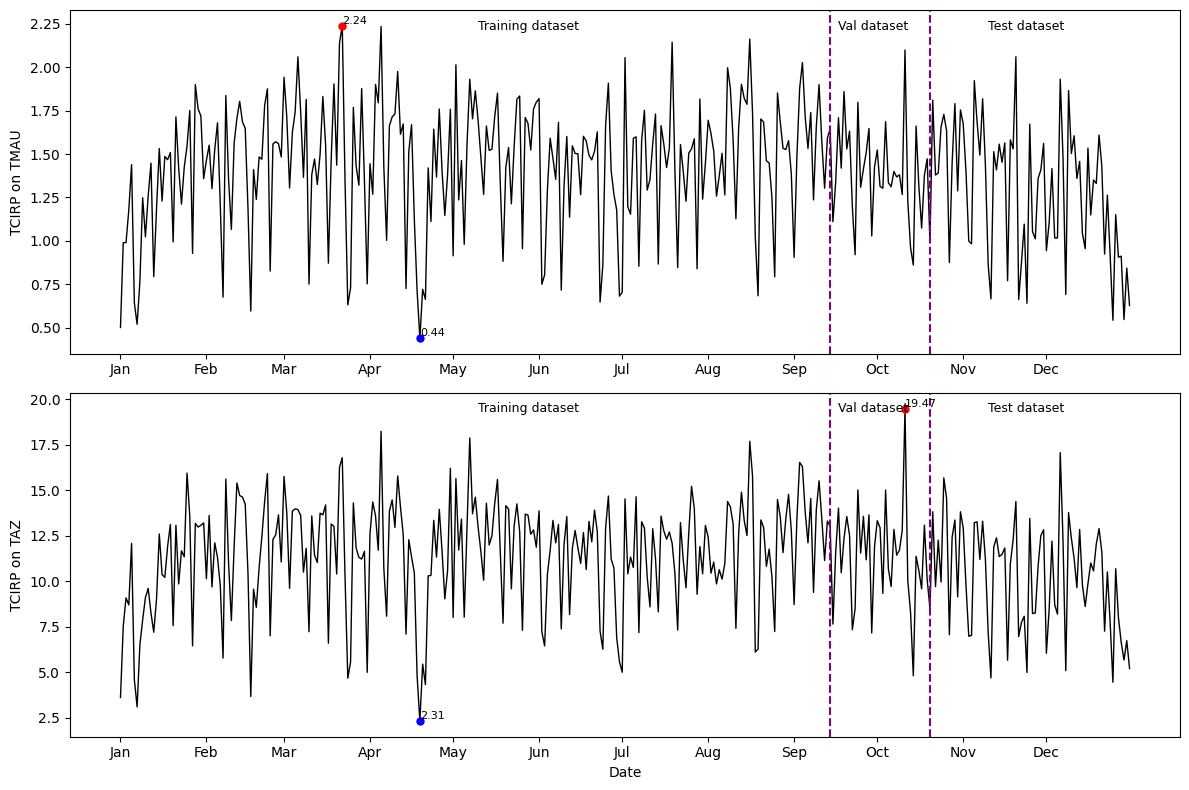

In [36]:
# Agrupar los valores por hora y calcular la suma de los valores
df_day = utam_col.groupby(utam_col['FECHA_HORA'].dt.date)['TC_I_UTAM'].sum()
df_day_taz = zat_col.groupby(zat_col['FECHA_HORA'].dt.date)['TC_I_ZAT'].sum()

# Crear subgráficos
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# Etiquetas y datos para cada subgráfico
subplots_data = [
    {'df': df_day, 'ax': axes[0], 'label': 'TCIRP on TMAU'},
    {'df': df_day_taz, 'ax': axes[1], 'label': 'TCIRP on TAZ'},
]

for subplot_data in subplots_data:
    df = subplot_data['df']
    ax = subplot_data['ax']
    # Gráfica
    ax.plot(df.index, df, color='black', linewidth=1)
    ax.set_ylabel(subplot_data['label'])
    # Máximos y mínimos
    max_day = df.idxmax()
    max_accidents = df.max()
    min_day = df.idxmin()
    min_accidents = df.min()
    ax.plot(max_day, max_accidents, 'ro', label="Peak", markersize=5)
    ax.annotate(round(max_accidents, 2), (max_day, max_accidents), fontsize=8, va='bottom', ha='left')
    ax.plot(min_day, min_accidents, 'bo', label="Valley", markersize=5)
    ax.annotate(round(min_accidents, 2), (min_day, min_accidents), fontsize=8, va='bottom', ha='left')
    # Marcado de las muestras
    indices_to_mark = ['2019-09-14', '2019-10-20']
    indices_to_mark = [datetime.strptime(date, '%Y-%m-%d') for date in indices_to_mark]
    for index in indices_to_mark:
        ax.axvline(x=index, color='purple', linestyle='--')

# Configuraciones finales
axes[-1].set_xlabel('Date')
# Establecer las etiquetas en el eje X para ambos subgráficos
for ax in axes:
    # Obtener los índices para el día 1 de cada mes
    indices_day_1 = [date.replace(day=1) for date in df.index if date.day == 1]
    ax.set_xticks(indices_day_1)
    ax.set_xticklabels([day.strftime('%b') for day in indices_day_1], fontsize=10, ha='center')
    # Etiquetas de conjunto de datos
    ax.text(datetime(2019, 5, 10), ax.get_ylim()[1] * 0.95, 'Training dataset', fontsize=9, color='black')
    ax.text(datetime(2019, 9, 17), ax.get_ylim()[1] * 0.95, 'Val dataset', fontsize=9, color='black')
    ax.text(datetime(2019, 11, 10), ax.get_ylim()[1] * 0.95, 'Test dataset', fontsize=9, color='black')


# Mostrar la gráfica
plt.tight_layout()
plt.show()

## Modeling

La arquitectura de la Red Neuronal Artificial a implementar se detalla en la siguiente imagen:

Modelo 1:

In [37]:
# Variables Tipe I: Only spatially varied but temporally static
class Model1:
    def __init__(self, input_shape):
        self.input = Input(shape=input_shape)
        x = Conv1D(512, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(self.input)
        x = BatchNormalization()(x)
        x = Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
        x = Dropout(0.5)(x)
        x = Conv1D(128, 3, activation='relu', padding='same')(x)
        x = Dropout(0.5)(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = Flatten()(x)
        self.output = Dense(1)(x)
        self.model = Model(inputs=self.input, outputs=self.output)

# Variables Tipe II: Only temporally varied but spatially static
class Model2:
    def __init__(self, input_shape):
        self.input = Input(shape=input_shape)
        x = GRU(512, return_sequences=True, kernel_regularizer=l2(0.01))(self.input)
        x = BatchNormalization()(x)
        x = GRU(256)(x)
        x = Dropout(0.5)(x)
        self.output = Dense(1)(x)
        self.model = Model(inputs=self.input, outputs=self.output)

# Variables Tipe III: Both spatially and temporally varied
class Model3:
    def __init__(self, input_shape):
        self.input = Input(shape=input_shape)
        x = ConvLSTM2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True, kernel_regularizer=l2(0.01))(self.input)
        x = Dropout(0.5)(x)
        x = ConvLSTM2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
        self.output = Flatten()(x)
        self.output = Dense(1)(self.output)
        self.model = Model(inputs=self.input, outputs=self.output)

# Feature merge layer + Fully connected layers X 2
class CombinedModel:
    def __init__(self, model1, model2, model3):
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.input1 = model1.input
        self.input2 = model2.input
        self.input3 = model3.input
        combined_input = Concatenate()([model1.output, model2.output, model3.output])
        # Agrega capas completamente conectadas
        x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(combined_input)
        x = Dropout(0.5)(x)  # Agrega una capa de Dropout
        x = Dense(256, activation='relu')(x)
        # Capa de salida para predicciones
        prediction = Dense(1, activation='linear')(x)
        self.model = Model(inputs=[self.input1, self.input2, self.input3], outputs=prediction)

    def compile(self, optimizer, loss):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y, epochs, batch_size, validation_data):
        self.model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    def predict(self, x):
        # Realiza predicciones utilizando tus modelos internos y combina las salidas
        predictions1 = self.model1.model.predict(x[0])
        predictions2 = self.model2.model.predict(x[1])
        predictions3 = self.model3.model.predict(x[2])

        # Combina las predicciones mediante el promedio
        combined_predictions = (predictions1 + predictions2 + predictions3) / 3
        return combined_predictions

Ahora reformemos los datos para que coincidan con las expectativas de cada uno de los modelos, asegurando de que tengan las dimensiones correctas.

In [38]:
# La primer capa del Model1 es una convolucional 1D, por lo que su entrada tendrá la forma
#                 (número_de_muestras, longitud_de_la_secuencia, número_de_características)
x_t1_train_reshaped = X_train_t1.reshape(X_train_t1.shape[0], X_train_t1.shape[1], 1)
x_t1_test_reshaped = X_test_t1.reshape(X_test_t1.shape[0], X_test_t1.shape[1], 1)
x_t1_val_reshaped = X_val_t1.reshape(X_val_t1.shape[0], X_val_t1.shape[1], 1)
# La primer capa del Model2 es una layer GRU, por lo que su entrada debe tener la forma
#                 (número_de_muestras, longitud_de_la_secuencia, número_de_características)
x_t2_train_reshaped = X_train_t2.reshape(X_train_t2.shape[0], X_train_t2.shape[1], 1)
x_t2_test_reshaped = X_test_t2.reshape(X_test_t2.shape[0], X_test_t2.shape[1], 1)
x_t2_val_reshaped = X_val_t2.reshape(X_val_t2.shape[0], X_val_t2.shape[1], 1)
# La primer capa del Model3 es una layer convolucional LSTM 2D, por lo que su entrada deben tener la forma
#                 (número_de_muestras, longitud_de_la_secuencia, número_de_filas, número_de_columnas, número_de_características)
# TC_I_UTAM
tc_i_utam_train_reshaped = y_train_tc_i_utam.reshape(y_train_tc_i_utam.shape[0], 1, 1, 1, y_train_tc_i_utam.shape[-1])
tc_i_utam_test_reshaped = y_test_tc_i_utam.reshape(y_test_tc_i_utam.shape[0], 1, 1, 1, y_test_tc_i_utam.shape[-1])
tc_i_utam_val_reshaped = y_val_tc_i_utam.reshape(y_val_tc_i_utam.shape[0], 1, 1, 1, y_val_tc_i_utam.shape[-1])

Instanciemos las clases

In [39]:
# Definir el input_shape
input_shape_t1 = (x_t1_train_reshaped.shape[1], x_t1_train_reshaped.shape[2])
input_shape_t2 = (x_t2_train_reshaped.shape[1], x_t2_train_reshaped.shape[2])
input_shape_t3_tc_i_utam = (tc_i_utam_train_reshaped.shape[1], tc_i_utam_train_reshaped.shape[2],
                            tc_i_utam_train_reshaped.shape[3], tc_i_utam_train_reshaped.shape[-1])
# Instanciando los modelos
model1_ins = Model1(input_shape_t1)
model2_ins = Model2(input_shape_t2)
#model3_tc_i_utam_ins = Model3(input_shape_t3_tc_i_utam)
model3_tc_i_utam_ins = Model3(input_shape_t3_tc_i_utam)
# Instanciando el modelo que une los tres modelos para TC_I_UTAM
combined_model_tc_i_utam_ins = CombinedModel(model1_ins.model, model2_ins.model, model3_tc_i_utam_ins.model)

Veamos la arquitectura de los modelos combinados

In [40]:
combined_model_tc_i_utam_ins.model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 13, 512)   │      2,048 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 13, 512)   │      2,048 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 13, 256)   │    393,472 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 13, 256)   │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 3, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1, 1, 1,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 13, 128)   │     98,432 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 3, 512)    │    791,040 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 1, 1, 1,   │  9,457,664 │ input_layer_2[0]… │
│ (ConvLSTM2D)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 13, 128)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 512)    │      2,048 │ gru[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1, 1, 1,   │          0 │ conv_lstm2d[0][0] │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 6, 128)    │          0 │ dropout_1[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 256)       │    591,360 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 1, 1, 256) │  7,078,912 │ dropout_3[0][0]   │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 256)       │          0 │ conv_lstm2d_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        769 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 18,551,940 (70.77 MB)

 Trainable params: 18,549,892 (70.76 MB)

 Non-trainable params: 2,048 (8.00 KB)

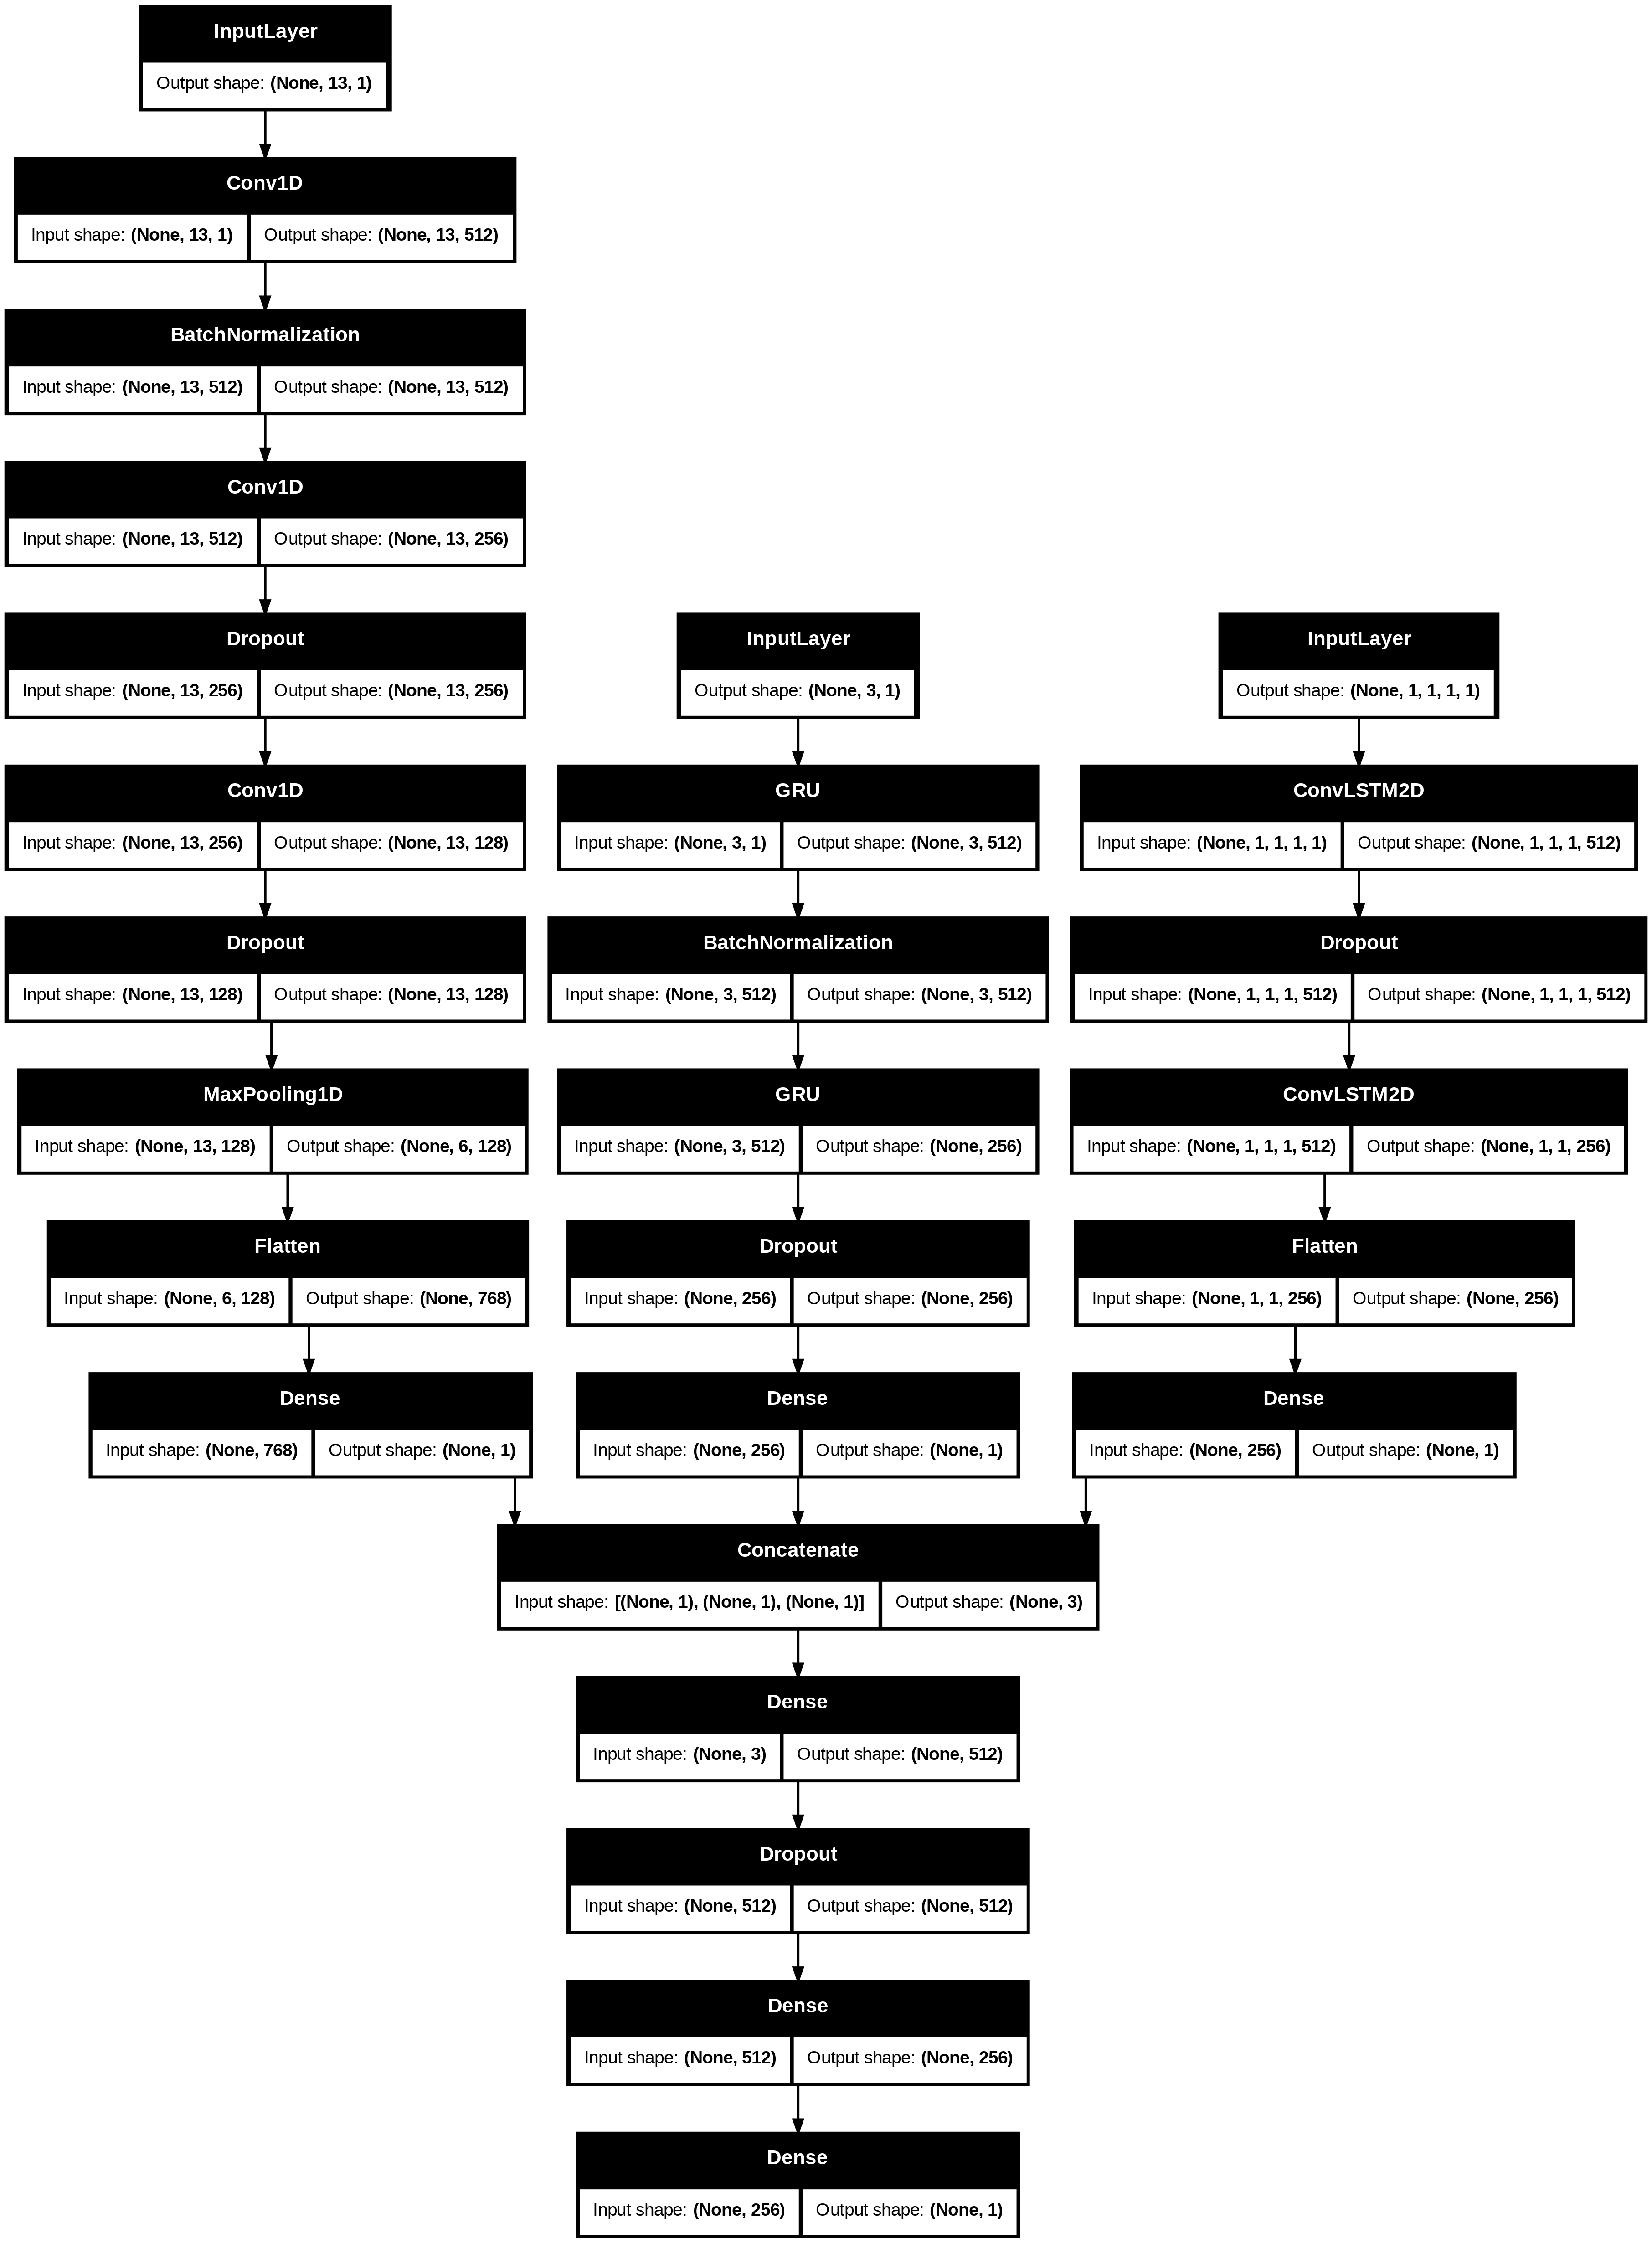

In [41]:
tf.keras.utils.plot_model(combined_model_tc_i_utam_ins.model,show_shapes=True)

Definamos los callbacks

In [42]:
# Definir el callback para guardar el mejor modelo
# TC_I_UTAM
best_callback = tf.keras.callbacks.ModelCheckpoint(filepath="best_model_tcirp_tmau.weights.h5", monitor="val_loss",
                                                   verbose=True, save_best_only=True,
                                                   save_weights_only=True, mode="min")

# Definir el callback para detener el entrenamiento cuando detecte convergencia
# de épocas (patience), y las mejoras se consideran sólamente si la métrica ha cambiado más de un valor de umbral (min_delta)
early_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, min_delta=0.0001, verbose=True)

Compilemos los modelos

In [43]:
# Compilar CombinedModel TC_I_UTAM
combined_model_tc_i_utam_ins.model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae','mape'])

Entrenemos los modelos

In [ ]:
%%time
# Entrenar CombinedModel TC_I_UTAM
hist_tc_i_utam = combined_model_tc_i_utam_ins.model.fit([x_t1_train_reshaped, x_t2_train_reshaped, tc_i_utam_train_reshaped],
                                                        y_train_tc_i_utam, epochs=100, batch_size=64,callbacks=[best_callback, early_callback],
                                                        validation_data=([x_t1_test_reshaped, x_t2_test_reshaped, tc_i_utam_test_reshaped],
                                                        y_test_tc_i_utam))

Epoch 1/100
10540/10540 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1975 - mae: 0.0601 - mape: 22.2414 - mse: 0.1076
Epoch 1: val_loss improved from inf to 0.01414, saving model to best_model_tcirp_tmau.weights.h5
10540/10540 ━━━━━━━━━━━━━━━━━━━━ 461s 42ms/step - loss: 0.1975 - mae: 0.0601 - mape: 22.2406 - mse: 0.1076 - val_loss: 0.0141 - val_mae: 0.0102 - val_mape: 1.6172 - val_mse: 0.0055
Epoch 2/100
10539/10540 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0244 - mae: 0.0180 - mape: 3.2111 - mse: 0.0179
Epoch 2: val_loss improved from 0.01414 to 0.00984, saving model to best_model_tcirp_tmau.weights.h5
10540/10540 ━━━━━━━━━━━━━━━━━━━━ 441s 42ms/step - loss: 0.0244 - mae: 0.0180 - mape: 3.2111 - mse: 0.0179 - val_loss: 0.0098 - val_mae: 0.0056 - val_mape: 0.4981 - val_mse: 0.0053
Epoch 3/100
10539/10540 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0260 - mae: 0.0183 - mape: 3.0643 - mse: 0.0210
Epoch 3: val_loss improved from 0.00984 to 0.00944, saving model to best_model_tcirp_tmau.we

Descarguemos el mejor modelo

In [ ]:
files.download('best_model_tcirp_tmau.weights.h5')

Visualicemos el rendimiento del modelo

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(hist_tc_i_utam.history["loss"], label="Entrenamiento")
plt.plot(hist_tc_i_utam.history["val_loss"], label="Validación")
plt.xlabel("Época"); plt.ylabel("Pérdida")
plt.legend()

In [ ]:
# Realiza predicciones
tc_i_utam_pred_test = combined_model_tc_i_utam_ins.model.predict([x_t1_test_reshaped, x_t2_test_reshaped, tc_i_utam_test_reshaped])
tc_i_utam_pred_val = combined_model_tc_i_utam_ins.model.predict([x_t1_val_reshaped, x_t2_val_reshaped, tc_i_utam_val_reshaped])
tc_i_utam_pred_train = combined_model_tc_i_utam_ins.model.predict([x_t1_train_reshaped, x_t2_train_reshaped, tc_i_utam_train_reshaped])

Veamos las métricas del modelo con los datos de prueba

In [ ]:
def regression_report(y_real, y_pred):
    mse = mean_squared_error(y_real, y_pred)
    mae = mean_absolute_error(y_real, y_pred)
    mape = mean_absolute_percentage_error(y_real, y_pred) * 100
    r2 = r2_score(y_real, y_pred)
    data = {
        'MSE': [mse],
        'MAE': [mae],
        'MAPE': [mape],
        'R²': [r2]
    }
    report = pd.DataFrame(data)
    return report

In [ ]:
# Metricas test
tc_i_utam_test_metrics = regression_report(tc_i_utam_test_reshaped.ravel(), tc_i_utam_pred_test)
tc_i_utam_test_metrics


In [ ]:
# Metricas val
tc_i_utam_val_metrics = regression_report(tc_i_utam_val_reshaped.ravel(), tc_i_utam_pred_val)
tc_i_utam_val_metrics

In [ ]:
# Métricas train
tc_i_utam_train_metrics = regression_report(tc_i_utam_train_reshaped.ravel(), tc_i_utam_pred_train)
tc_i_utam_train_metrics

In [ ]:
obs = tc_i_utam_val_reshaped.ravel()
pred = tc_i_utam_pred_val.ravel()
df = pd.DataFrame({'ID': range(len(tc_i_utam_pred_val)), 'Observado': obs, 'Predicho': pred})
plt.scatter(df['ID'], df['Observado'], label='Observado', color='blue', marker='o', s=10)
plt.scatter(df['ID'], df['Predicho'], label='Predicho', color='red', marker='x', s=10)


Observemos las predicciones en los valores no observados (Val)

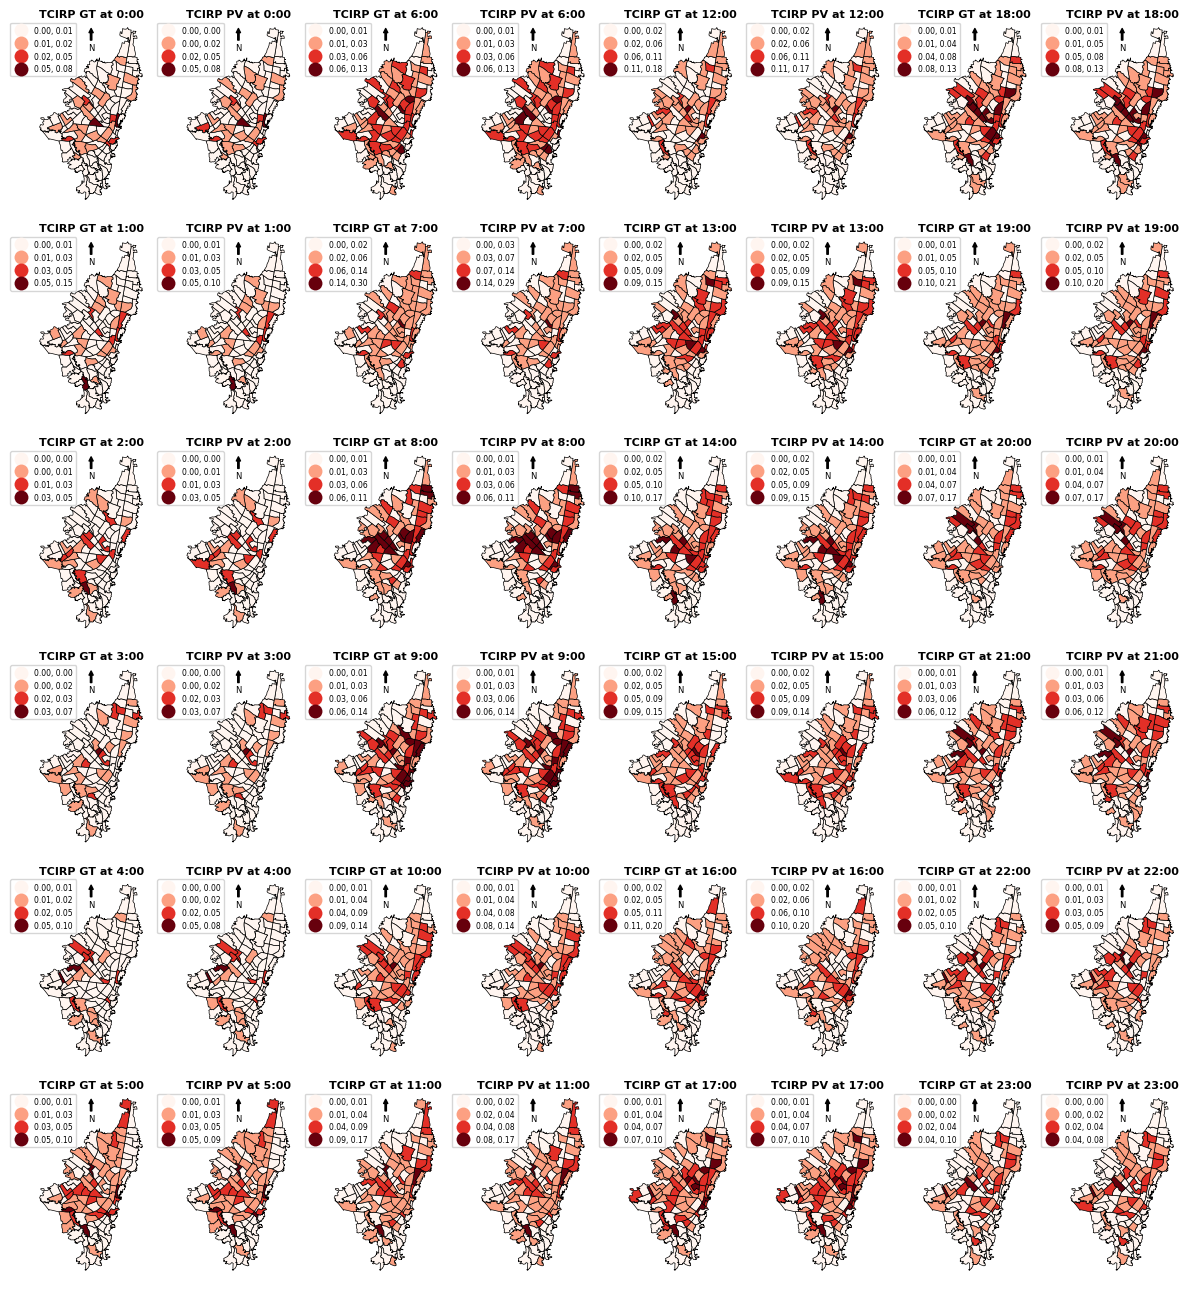

In [ ]:
# Val sample
utam_index = len(utam_col)
# Destransformemos los valores predichos del TCIRP UTAM
# Aplica la transformación inversa
tc_i_utam_pred_det = transformer_tc_i_utam.named_transformers_['numeric_y'].inverse_transform(tc_i_utam_pred_val.flatten().reshape(-1, 1))
# Dataframe con valores observados y predichos de TCIRP UTAM
tcirp_utam = pd.DataFrame({'TCIRP_OBS': utam_col['TC_I_UTAM'][(int(0.70 * utam_index)) : (int(0.8 * utam_index))], 'TCIRP_PRED': tc_i_utam_pred_det.flatten()})
# Obtener los valores de la muestra val del dataframe con hora y fecha
utam_col_val_sample = utam_col[(int(0.70 * utam_index)) : (int(0.8 * utam_index))]
# Unir para recuperar los valores en el DF de valores obs y pred
tcirp_utam_hour = pd.concat([utam_col_val_sample, tcirp_utam], axis=1)
# Extrae la hora como 'H' en una nueva columna
tcirp_utam_hour['H'] = tcirp_utam_hour['FECHA_HORA'].dt.hour
# Agrupa por UTAM y Hora para obtener el agregado
utam_2019_hour = tcirp_utam_hour.groupby(['UTAM','H'])[['TCIRP_OBS','TCIRP_PRED']].sum().reset_index()
utam_2019_hour = utam_2019_hour.merge(utam[['UTAM', 'geometry']], on='UTAM', how='inner')
utam_2019_hour = gpd.GeoDataFrame(utam_2019_hour, geometry='geometry')

# Define el número de filas y columnas para la matriz de subplots
n_rows = 6
n_cols = 8
# Crea una figura con subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 13))
# Itera a través de las filas y columnas para crear los mapas coropléticos
for row in range(n_rows):
    for col in range(n_cols):
        # Calcula la hora correspondiente
        hour = (col * 6 + row) % 24
        # Filtra los datos para la hora específica
        data_hour = utam_2019_hour[utam_2019_hour['H'] == hour]
        # Verifica si la posición en la matriz de subplots es válida
        if 2 * col < n_cols:
            # Mapa coroplético para la variable 'TCIRP_OBS'
            data_hour.plot(column='TCIRP_OBS', scheme='NaturalBreaks', k=4, cmap='Reds', linewidth=0.5, ax=axs[row, 2 * col], edgecolor='black', legend=True, legend_kwds={'loc': 'upper left', 'fontsize': 5.5,'bbox_to_anchor': (-0.25, 1)})
            axs[row, 2 * col].set_title(f'TCIRP GT at {hour}:00', fontsize=8, fontweight='bold', pad=-5)
            axs[row, 2 * col].axis('off')
        if 2 * col + 1 < n_cols:
            # Mapa coroplético para la variable 'TCIRP_PRED'
            data_hour.plot(column='TCIRP_PRED', scheme='NaturalBreaks', k=4, cmap='Reds', linewidth=0.5, ax=axs[row, 2 * col + 1], edgecolor='black', legend=True, legend_kwds={'loc': 'upper left', 'fontsize':5.5,'bbox_to_anchor': (-0.25, 1)})
            axs[row, 2 * col + 1].set_title(f'TCIRP PV at {hour}:00', fontsize=8, fontweight='bold', pad=-5)
            axs[row, 2 * col + 1].axis('off')

        # Agregar norte y escala
        x, y, arrow_length = 0.5, 0.95, 0.1
        axs[row, col].annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                  arrowprops=dict(facecolor='black', width=1, headwidth=3,  headlength=3, shrink=0.001),
                  ha='center', va='center', fontsize=6,
                  xycoords=axs[row, col].transAxes)

# Ajusta la disposición de los subplots
plt.tight_layout()
# Muestra la figura
plt.show()

## Coropleta error relativo

In [ ]:
# --- Calcular MSE por UTAM y hora ---
utam_2019_hour['TCIRP_MSE'] = (utam_2019_hour['TCIRP_OBS'] - utam_2019_hour['TCIRP_PRED'])**2

# Normalizar MSE entre 0 y 1
scaler = MinMaxScaler()
utam_2019_hour['TCIRP_MSE_norm'] = scaler.fit_transform(utam_2019_hour[['TCIRP_MSE']])

# Asegurar que `utam` sea un GeoDataFrame con geometría válida
utam = gpd.GeoDataFrame(utam, geometry='geometry')

# Definir los bins fijos para todos los mapas
bins = [0.1, 0.2, 0.3]

# Crear figura de 4x6 (24 horas)
n_rows, n_cols = 4, 6
fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 13))

for hour in range(24):
    row = hour // n_cols
    col = hour % n_cols
    ax = axs[row, col]

    # Filtrar datos por hora
    data_hour = utam_2019_hour[utam_2019_hour['H'] == hour]

    # Dibujar fondo gris claro con todos los polígonos
    utam.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.3)

    # Dibujar polígonos con datos normalizados usando bins definidos
    data_hour.plot(
        column='TCIRP_MSE_norm',
        scheme='user_defined',
        classification_kwds={'bins': bins},
        cmap='Reds',  # Verde más intenso = mejor acierto (MSE bajo)
        linewidth=0.5,
        ax=ax,
        edgecolor='black',
        legend=True,
        legend_kwds={
            'loc': 'upper left',
            'fontsize': 6,
            'bbox_to_anchor': (-0.1, 1),
            'markerscale': 0.7,
            'frameon': False,
            'title': 'MSE norm'
        }
    )

    ax.set_title(f'TCIRP at {hour}:00', fontsize=8, fontweight='bold', pad=-5)
    ax.axis('off')

    # Flecha norte
    ax.annotate('N', xy=(0.5, 0.95), xytext=(0.5, 0.85),
                arrowprops=dict(facecolor='black', width=1, headwidth=3, headlength=3, shrink=0.001),
                ha='center', va='center', fontsize=6,
                xycoords=ax.transAxes)

plt.tight_layout()
plt.show()

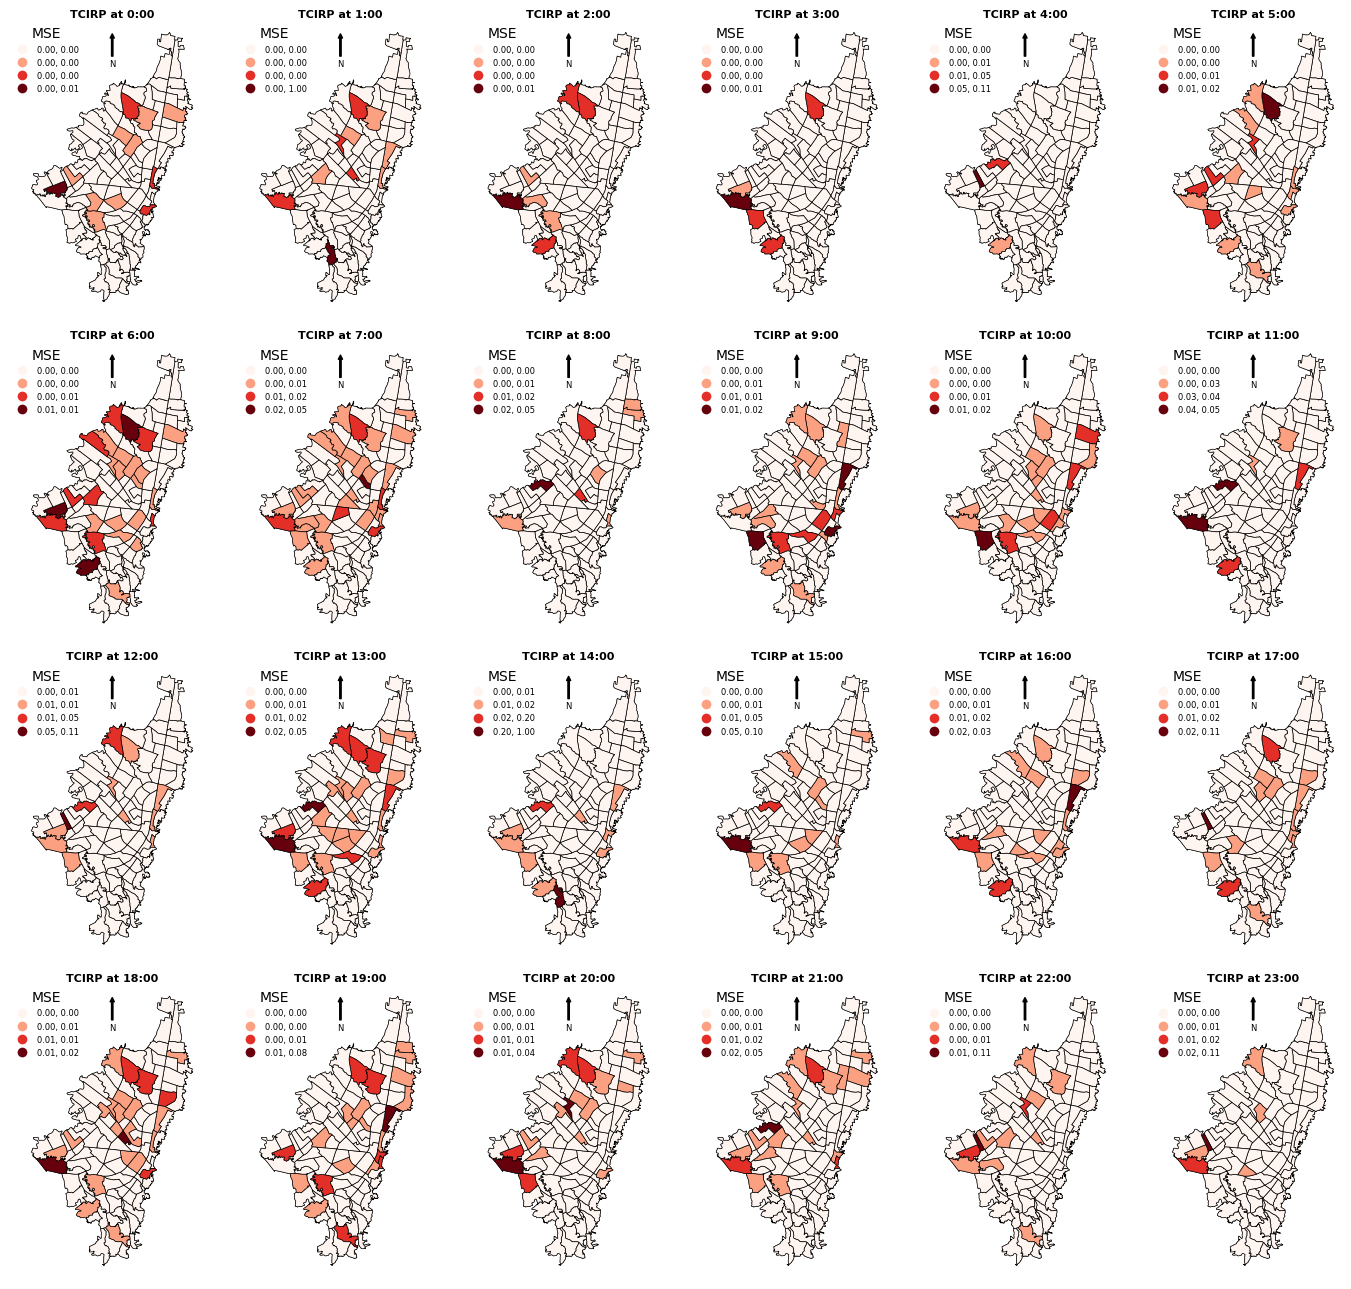

In [ ]:
# --- Calcular MSE por UTAM y hora ---
utam_2019_hour['TCIRP_MSE'] = (utam_2019_hour['TCIRP_OBS'] - utam_2019_hour['TCIRP_PRED'])**2

# Normalizar MSE de 0 a 1 para facilitar la visualización
scaler = MinMaxScaler()
utam_2019_hour['TCIRP_MSE_norm'] = scaler.fit_transform(utam_2019_hour[['TCIRP_MSE']])

# Crear figura con 4 filas y 6 columnas
n_rows, n_cols = 4, 6
fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 13))

for hour in range(24):
    row = hour // n_cols
    col = hour % n_cols
    ax = axs[row, col]

    # Filtrar datos por hora
    data_hour = utam_2019_hour[utam_2019_hour['H'] == hour]

    # Dibujar fondo gris claro con todos los polígonos
    utam.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.3)

    # Dibujar polígonos con datos normalizados usando Quantiles
    data_hour.plot(
        column='TCIRP_MSE_norm',
        scheme='NaturalBreaks',
        k=4,
        cmap='Reds',
        linewidth=0.5,
        ax=ax,
        edgecolor='black',
        legend=True,
        legend_kwds={
            'loc': 'upper left',
            'fontsize': 6,
            'bbox_to_anchor': (-0.1, 1),
            'markerscale': 0.7,
            'frameon': False,
            'title': 'MSE'
        }
    )

    ax.set_title(f'TCIRP at {hour}:00', fontsize=8, fontweight='bold', pad=-5)
    ax.axis('off')

    # Agregar flecha norte
    ax.annotate('N', xy=(0.5, 0.95), xytext=(0.5, 0.85),
                arrowprops=dict(facecolor='black', width=1, headwidth=3, headlength=3, shrink=0.001),
                ha='center', va='center', fontsize=6,
                xycoords=ax.transAxes)

plt.tight_layout()
plt.show()

In [ ]:
#zat_col.to_parquet('ZAT.parquet')
#files.download('ZAT.parquet')

## Fine tuning

Validación sobre ZAT

In [ ]:
zat = pd.read_parquet('ZAT.parquet')

In [ ]:
colum = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11_X12','X13', 'X14', 'X15', 'X16', 'TC_I_ZAT']
zat = zat[colum]

In [ ]:
len(zat)

In [ ]:
zat = zat[zat['TC_I_ZAT']!=0]

Generemos las transformaciones

In [ ]:
def tranforma(df):
    # Type I
    numeric_t1 = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11_X12','X13','X14']
    # Type II
    numeric_t2 = ['X15']
    nominal = ['X16']
    # Type III
    numeric_y = ['TC_I_ZAT']
    # Exogenous Type I variables transformation
    transformer_x_t1 = ColumnTransformer(
            transformers=[
                ("numeric_t1", StandardScaler(), numeric_t1)
                ]
            )
    # Exogenous Type II variables transformation
    transformer_x_t2 = ColumnTransformer(
            transformers=[
                ("numeric_t2", StandardScaler(), numeric_t2),
                ("nominal", OneHotEncoder(), nominal)
                ]
            )
    # Endogenous Type III variable transformation TC_I_UTAM
    transformer_tc_i_zat = ColumnTransformer(
            transformers=[
                ("numeric_y", StandardScaler(), numeric_y)
                ],remainder='drop'  # Mantener las columnas no seleccionadas sin cambios
            )
    # Exogenous Type I variables transformation
    x_t1 = transformer_x_t1.fit_transform(df)
    # Exogenous Type II variables transformation
    x_t2 = transformer_x_t2.fit_transform(df)
    # Endogenous Type III variable transformation TC_I_UTAM
    tc_i_zat_tr = transformer_tc_i_zat.fit_transform(df)
    return x_t1,x_t2, tc_i_zat_tr


In [ ]:
x_t1_zat, x_t2_zat, tc_i_zat_tr = tranforma(zat)

Dividamos los datos de entrenamiento y prueba, en este caso utilizamos una partición: 70% de entrenamiento, 20% para pruebas, 10% para validación (Forecasting) como es común en tareas de aprendizaje de máquina

In [ ]:
# Valores diferentes de 0
zat_index = len(x_t1_zat)
# Train (70%) - Test (20%) - Val (10%) sample exogenous Type I & II variables
X_train_t1, X_train_t2= x_t1_zat, x_t2_zat
X_test_t1, X_test_t2 = x_t1_zat, x_t2_zat
X_val_t1, X_val_t2 = x_t1_zat[(int(0.70 * zat_index)) : (int(0.8 * zat_index))], x_t2_zat[(int(0.70 * zat_index)) : (int(0.8 * zat_index))]
#---------------------------------------------------------------------------------------------------------------------------
# Train (70%) - Test (20%) - Val (10%) sample endogenous Type III variables
y_train_tc_i_zat = tc_i_zat_tr
y_test_tc_i_zat = tc_i_zat_tr
y_val_tc_i_zat = tc_i_zat_tr[(int(0.70 * zat_index)) : (int(0.8 * zat_index))]

In [ ]:
zat_index = len(x_t1_zat)
# Train (70%) - Test (20%) - Val (10%) sample exogenous Type I & II variables
X_train_t1, X_train_t2= x_t1_zat[ : int(0.7 * zat_index)], x_t2_zat[ : int(0.7 * zat_index)]
X_test_t1, X_test_t2 = x_t1_zat[int(0.8 * zat_index) : ], x_t2_zat[int(0.8 * zat_index) : ]
X_val_t1, X_val_t2 = x_t1_zat[(int(0.70 * zat_index)) : (int(0.8 * zat_index))], x_t2_zat[(int(0.70 * zat_index)) : (int(0.8 * zat_index))]
#---------------------------------------------------------------------------------------------------------------------------
# Train (70%) - Test (20%) - Val (10%) sample endogenous Type III variables
y_train_tc_i_zat = tc_i_zat_tr[ : int(0.7 * zat_index)]
y_test_tc_i_zat = tc_i_zat_tr[int(0.8 * zat_index) : ]
y_val_tc_i_zat = tc_i_zat_tr[(int(0.70 * zat_index)) : (int(0.8 * zat_index))]

Ahora reformemos los datos para que coincidan con las expectativas de cada uno de los modelos, asegurando de que tengan las dimensiones correctas.

In [ ]:
# La primer capa del Model1 es una convolucional 1D, por lo que su entrada tendrá la forma
#                 (número_de_muestras, longitud_de_la_secuencia, número_de_características)
x_t1_train_reshaped = X_train_t1.reshape(X_train_t1.shape[0], X_train_t1.shape[1], 1)
x_t1_test_reshaped = X_test_t1.reshape(X_test_t1.shape[0], X_test_t1.shape[1], 1)
x_t1_val_reshaped = X_val_t1.reshape(X_val_t1.shape[0], X_val_t1.shape[1], 1)
# La primer capa del Model2 es una layer GRU, por lo que su entrada debe tener la forma
#                 (número_de_muestras, longitud_de_la_secuencia, número_de_características)
x_t2_train_reshaped = X_train_t2.reshape(X_train_t2.shape[0], X_train_t2.shape[1], 1)
x_t2_test_reshaped = X_test_t2.reshape(X_test_t2.shape[0], X_test_t2.shape[1], 1)
x_t2_val_reshaped = X_val_t2.reshape(X_val_t2.shape[0], X_val_t2.shape[1], 1)
# La primer capa del Model3 es una layer convolucional LSTM 2D, por lo que su entrada deben tener la forma
#                 (número_de_muestras, longitud_de_la_secuencia, número_de_filas, número_de_columnas, número_de_características)
# TC_I_UTAM
tc_i_zat_train_reshaped = y_train_tc_i_zat.reshape(y_train_tc_i_zat.shape[0], 1, 1, 1, y_train_tc_i_zat.shape[-1])
tc_i_zat_test_reshaped = y_test_tc_i_zat.reshape(y_test_tc_i_zat.shape[0], 1, 1, 1, y_test_tc_i_zat.shape[-1])
tc_i_zat_val_reshaped = y_val_tc_i_zat.reshape(y_val_tc_i_zat.shape[0], 1, 1, 1, y_val_tc_i_zat.shape[-1])

Instanciemos las clases

In [ ]:
# Definir el input_shape
input_shape_t1 = (x_t1_train_reshaped.shape[1], x_t1_train_reshaped.shape[2])
input_shape_t2 = (x_t2_train_reshaped.shape[1], x_t2_train_reshaped.shape[2])
input_shape_t3_tc_i_zat = (tc_i_zat_train_reshaped.shape[1], tc_i_zat_train_reshaped.shape[2],
                            tc_i_zat_train_reshaped.shape[3], tc_i_zat_train_reshaped.shape[-1])
# Instanciando los modelos
model1_ins = Model1(input_shape_t1)
model2_ins = Model2(input_shape_t2)
#model3_tc_i_utam_ins = Model3(input_shape_t3_tc_i_utam)
model3_tc_i_zat_ins = Model3(input_shape_t3_tc_i_zat)
# Instanciando el modelo que une los tres modelos para TC_I_UTAM
combined_model_tc_i_zat_ins = CombinedModel(model1_ins.model, model2_ins.model, model3_tc_i_zat_ins.model)

Instancia del modelo y carga de los pesos

In [ ]:
combined_model_tc_i_zat_ins.load_weights('best_model_tcirp_tmau.h5')

In [ ]:
# Fine tuning
# Congelar las capas del modelo preentrenado
for layer in combined_model_tc_i_zat_ins.model.layers:
    layer.trainable = False

# Agregar nuevas capas más potentes al modelo
new_layers = Dense(2048, activation='relu')(combined_model_tc_i_zat_ins.model.output)
new_layers = Dropout(0.5)(new_layers)
new_layers = Dense(1024, activation='relu')(new_layers)
new_layers = Dropout(0.5)(new_layers)
new_layers = Dense(512, activation='relu')(new_layers)
new_layers = Dropout(0.5)(new_layers)
# Capa de Regresión Poissoniana
new_output = Dense(1, activation='exponential')(new_layers)

In [ ]:
# Crear un nuevo modelo con las capas añadidas
fine_tuned_model = Model(inputs=combined_model_tc_i_zat_ins.model.inputs, outputs=new_output)
# Compilar el modelo
fine_tuned_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae','mape'])

In [ ]:
# Definir el callback para guardar el mejor modelo
# TC_I_UTAM
best_callback_zat = tf.keras.callbacks.ModelCheckpoint(filepath="best_model_tcirp_taz.h5", monitor="val_loss",
                                                   verbose=True, save_best_only=True,
                                                   save_weights_only=True, mode="min")

# Definir el callback para detener el entrenamiento cuando detecte convergencia
# de épocas (patience), y las mejoras se consideran sólamente si la métrica ha cambiado más de un valor de umbral (min_delta)
early_callback_zat = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, min_delta=0.0001, verbose=True)

In [ ]:
fine_tuned_model.summary()

In [ ]:
%%time
# Fine-tunear el modelo con los nuevos datos
hist_tc_i_zat = fine_tuned_model.fit([x_t1_train_reshaped, x_t2_train_reshaped, tc_i_zat_train_reshaped],
                                                        y_train_tc_i_zat, epochs=100, batch_size=64,callbacks=[best_callback_zat, early_callback_zat],
                                                        validation_data=([x_t1_test_reshaped, x_t2_test_reshaped, tc_i_zat_test_reshaped],
                                                        y_test_tc_i_zat))

In [ ]:
files.download('best_model_tcirp_taz.h5')

Valores diferentes de 0

In [ ]:
# Realiza predicciones
tc_i_zat_pred_val = fine_tuned_model.predict([x_t1_val_reshaped, x_t2_val_reshaped, tc_i_zat_val_reshaped])
tc_i_zat_pred_test = fine_tuned_model.predict([x_t1_test_reshaped, x_t2_test_reshaped, tc_i_zat_test_reshaped])
tc_i_zat_pred_train = fine_tuned_model.predict([x_t1_train_reshaped, x_t2_train_reshaped, tc_i_zat_train_reshaped])

In [ ]:
# Metricas val
tc_i_zat_val_metrics = regression_report(tc_i_zat_val_reshaped.ravel(), tc_i_zat_pred_val)
tc_i_zat_val_metrics

In [ ]:
# Metricas train
tc_i_zat_train_metrics = regression_report(tc_i_zat_train_reshaped.ravel(), tc_i_zat_pred_train)
tc_i_zat_train_metrics

In [ ]:
obs_z = tc_i_zat_train_reshaped.ravel()
pred_z = tc_i_zat_pred_train.ravel()
df_z = pd.DataFrame({'ID': range(len(tc_i_zat_pred_train)), 'Observado': obs_z, 'Predicho': pred_z})
plt.scatter(df_z['ID'], df_z['Observado'], label='Observado', color='blue', marker='o', s=5)
plt.scatter(df_z['ID'], df_z['Predicho'], label='Predicho', color='red', marker='x', s=5)

Ahora si sobre todos los valores

In [ ]:
zat = pd.read_parquet('ZAT.parquet')

In [ ]:
colum = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11_X12','X13', 'X14', 'X15', 'X16', 'TC_I_ZAT']
zat = zat[colum]

In [ ]:
len(zat)

Generemos las transformaciones

In [ ]:
x_t1_zat, x_t2_zat, tc_i_zat_tr = tranforma(zat)

Dividamos los datos de entrenamiento y prueba, en este caso utilizamos una partición: 70% de entrenamiento, 20% para pruebas, 10% para validación (Forecasting) como es común en tareas de aprendizaje de máquina

In [ ]:
zat_index = len(x_t1_zat)
# Train (70%) - Test (20%) - Val (10%) sample exogenous Type I & II variables
X_train_t1, X_train_t2= x_t1_zat[ : int(0.7 * zat_index)], x_t2_zat[ : int(0.7 * zat_index)]
X_test_t1, X_test_t2 = x_t1_zat[int(0.8 * zat_index) : ], x_t2_zat[int(0.8 * zat_index) : ]
X_val_t1, X_val_t2 = x_t1_zat[(int(0.70 * zat_index)) : (int(0.8 * zat_index))], x_t2_zat[(int(0.70 * zat_index)) : (int(0.8 * zat_index))]
#---------------------------------------------------------------------------------------------------------------------------
# Train (70%) - Test (20%) - Val (10%) sample endogenous Type III variables
y_train_tc_i_zat = tc_i_zat_tr[ : int(0.7 * zat_index)]
y_test_tc_i_zat = tc_i_zat_tr[int(0.8 * zat_index) : ]
y_val_tc_i_zat = tc_i_zat_tr[(int(0.70 * zat_index)) : (int(0.8 * zat_index))]

Ahora reformemos los datos para que coincidan con las expectativas de cada uno de los modelos, asegurando de que tengan las dimensiones correctas.

In [ ]:
# La primer capa del Model1 es una convolucional 1D, por lo que su entrada tendrá la forma
#                 (número_de_muestras, longitud_de_la_secuencia, número_de_características)
x_t1_train_reshaped = X_train_t1.reshape(X_train_t1.shape[0], X_train_t1.shape[1], 1)
x_t1_test_reshaped = X_test_t1.reshape(X_test_t1.shape[0], X_test_t1.shape[1], 1)
x_t1_val_reshaped = X_val_t1.reshape(X_val_t1.shape[0], X_val_t1.shape[1], 1)
# La primer capa del Model2 es una layer GRU, por lo que su entrada debe tener la forma
#                 (número_de_muestras, longitud_de_la_secuencia, número_de_características)
x_t2_train_reshaped = X_train_t2.reshape(X_train_t2.shape[0], X_train_t2.shape[1], 1)
x_t2_test_reshaped = X_test_t2.reshape(X_test_t2.shape[0], X_test_t2.shape[1], 1)
x_t2_val_reshaped = X_val_t2.reshape(X_val_t2.shape[0], X_val_t2.shape[1], 1)
# La primer capa del Model3 es una layer convolucional LSTM 2D, por lo que su entrada deben tener la forma
#                 (número_de_muestras, longitud_de_la_secuencia, número_de_filas, número_de_columnas, número_de_características)
# TC_I_UTAM
tc_i_zat_train_reshaped = y_train_tc_i_zat.reshape(y_train_tc_i_zat.shape[0], 1, 1, 1, y_train_tc_i_zat.shape[-1])
tc_i_zat_test_reshaped = y_test_tc_i_zat.reshape(y_test_tc_i_zat.shape[0], 1, 1, 1, y_test_tc_i_zat.shape[-1])
tc_i_zat_val_reshaped = y_val_tc_i_zat.reshape(y_val_tc_i_zat.shape[0], 1, 1, 1, y_val_tc_i_zat.shape[-1])

Total valores

In [ ]:
# Realiza predicciones
tc_i_zat_pred_val = fine_tuned_model.predict([x_t1_val_reshaped, x_t2_val_reshaped, tc_i_zat_val_reshaped])
tc_i_zat_pred_test = fine_tuned_model.predict([x_t1_test_reshaped, x_t2_test_reshaped, tc_i_zat_test_reshaped])
tc_i_zat_pred_train = fine_tuned_model.predict([x_t1_train_reshaped, x_t2_train_reshaped, tc_i_zat_train_reshaped])

In [ ]:
# Metricas val
tc_i_zat_val_metrics = regression_report(tc_i_zat_val_reshaped.ravel(), tc_i_zat_pred_val)
tc_i_zat_val_metrics

In [ ]:
# Metricas test
tc_i_zat_test_metrics = regression_report(tc_i_zat_test_reshaped.ravel(), tc_i_zat_pred_test)
tc_i_zat_test_metrics

In [ ]:
# Metricas train
tc_i_zat_train_metrics = regression_report(tc_i_zat_train_reshaped.ravel(), tc_i_zat_pred_train)
tc_i_zat_train_metrics

In [ ]:
obs_z = tc_i_zat_train_reshaped.ravel()
pred_z = tc_i_zat_pred_train.ravel()
df_z = pd.DataFrame({'ID': range(len(tc_i_zat_pred_train)), 'Observado': obs_z, 'Predicho': pred_z})
plt.scatter(df_z['ID'], df_z['Observado'], label='Observado', color='blue', marker='o', s=5)
plt.scatter(df_z['ID'], df_z['Predicho'], label='Predicho', color='red', marker='x', s=5)

In [ ]:
# Val sample
zat_index = len(zat_col)
# Destransformemos los valores predichos del TCIRP UTAM
# Aplica la transformación inversa
tc_i_zat_pred_det = transformer_tc_i_zat.named_transformers_['numeric_y'].inverse_transform(tc_i_zat_pred_val.flatten().reshape(-1, 1))
# Dataframe con valores observados y predichos de TCIRP UTAM
tcirp_zat = pd.DataFrame({'TCIRP_OBS': zat_col['TC_I_ZAT'][(int(0.70 * zat_index)) : (int(0.8 * zat_index))], 'TCIRP_PRED': tc_i_zat_pred_det.flatten()})
# Obtener los valores de la muestra val del dataframe con hora y fecha
zat_col_val_sample = zat_col[(int(0.70 * zat_index)) : (int(0.8 * zat_index))]
# Unir para recuperar los valores en el DF de valores obs y pred
tcirp_zat_hour = pd.concat([zat_col_val_sample, tcirp_zat], axis=1)
# Extrae la hora como 'H' en una nueva columna
tcirp_zat_hour['H'] = tcirp_zat_hour['FECHA_HORA'].dt.hour
# Agrupa por UTAM y Hora para obtener el agregado
zat_2019_hour = tcirp_zat_hour.groupby(['ZAT_','H'])[['TCIRP_OBS','TCIRP_PRED']].sum().reset_index()
zat_2019_hour = zat_2019_hour.merge(zat[['ZAT_', 'geometry']], on='ZAT_', how='inner')
zat_2019_hour = gpd.GeoDataFrame(zat_2019_hour, geometry='geometry')

# Define el número de filas y columnas para la matriz de subplots
n_rows = 6
n_cols = 8
# Crea una figura con subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 13))
# Itera a través de las filas y columnas para crear los mapas coropléticos
for row in range(n_rows):
    for col in range(n_cols):
        # Calcula la hora correspondiente
        hour = (col * 6 + row) % 24
        # Filtra los datos para la hora específica
        data_hour_z = zat_2019_hour[zat_2019_hour['H'] == hour]
        # Verifica si la posición en la matriz de subplots es válida
        if 2 * col < n_cols:
            # Mapa coroplético para la variable 'TCIRP_OBS'
            data_hour_z.plot(column='TCIRP_OBS', scheme='NaturalBreaks', k=4, cmap='Reds', linewidth=0.5, ax=axs[row, 2 * col], edgecolor='black', legend=True, legend_kwds={'loc': 'upper left', 'fontsize': 5.5,'bbox_to_anchor': (-0.25, 1)})
            axs[row, 2 * col].set_title(f'TCIRP GT at {hour}:00', fontsize=8, fontweight='bold', pad=-5)
            axs[row, 2 * col].axis('off')
        if 2 * col + 1 < n_cols:
            # Mapa coroplético para la variable 'TCIRP_PRED'
            data_hour_z.plot(column='TCIRP_PRED', scheme='NaturalBreaks', k=4, cmap='Reds', linewidth=0.5, ax=axs[row, 2 * col + 1], edgecolor='black', legend=True, legend_kwds={'loc': 'upper left', 'fontsize':5.5,'bbox_to_anchor': (-0.25, 1)})
            axs[row, 2 * col + 1].set_title(f'TCIRP PV at {hour}:00', fontsize=8, fontweight='bold', pad=-5)
            axs[row, 2 * col + 1].axis('off')

        # Agregar norte y escala
        x, y, arrow_length = 0.5, 0.95, 0.1
        axs[row, col].annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                  arrowprops=dict(facecolor='black', width=1, headwidth=3,  headlength=3, shrink=0.001),
                  ha='center', va='center', fontsize=6,
                  xycoords=axs[row, col].transAxes)

# Ajusta la disposición de los subplots
plt.tight_layout()
# Muestra la figura
plt.show()

## Model Comparison

Transformemos las variables

In [ ]:
# Type I y
numerics = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11_X12','X13','X14','X15']
# Type II
nominals = ['X16']
# Type III
numerics_y = ['TC_I_UTAM']

# Exogenous Type I variables transformation
transformers_x = ColumnTransformer(
        transformers=[
            ("numerics", StandardScaler(), numerics),
            ("nominals", OneHotEncoder(), nominals)
            ]
        )

# Endogenous Type III variable transformation TC_I_UTAM
transformers_tc_i_utam = ColumnTransformer(
        transformers=[
            ("numerics_y", StandardScaler(), numerics_y)
            ],remainder='drop'  # Mantener las columnas no seleccionadas sin cambios
        )

Transformemos

In [ ]:
# Exogenous Type I variables transformation
x_t = transformers_x.fit_transform(utam_col)
# Endogenous Type III variable transformation TC_I_UTAM
tc_i_utam_t = transformers_tc_i_utam.fit_transform(utam_col)

Dividamos los datos de entrenamiento y prueba, en este caso utilizamos una partición: 70% de entrenamiento, 20% para pruebas, 10% para validación (Forecasting) como es común en tareas de aprendizaje de máquina

In [ ]:
utam_index = len(x_t)
# Train (70%) - Test (20%) - Val (10%) sample exogenous Type I & II variables
X_train_t = x_t[ : int(0.7 * utam_index)]
X_test_t = x_t[int(0.8 * utam_index) : ]
X_val_t = x_t[(int(0.70 * utam_index)) : (int(0.8 * utam_index))]
#---------------------------------------------------------------------------------------------------------------------------
# Train (70%) - Test (20%) - Val (10%) sample endogenous Type III variables
y_train_tc_i_utam_t = tc_i_utam_t[ : int(0.7 * utam_index)]
y_test_tc_i_utam_t = tc_i_utam_t[int(0.8 * utam_index) : ]
y_val_tc_i_utam_t = tc_i_utam_t[(int(0.70 * utam_index)) : (int(0.8 * utam_index))]

Definamos las clases de los modelos extra

In [ ]:
class CnnModels:
    def __init__(self, model_type, input_shape, epochs=10, batch_size=32):
        self.model_type = model_type
        self.input_shape = input_shape
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        model_input = Input(shape=self.input_shape)

        if self.model_type == 'cnn':
            x = Conv1D(64, kernel_size=3, activation='relu')(model_input)
            x = MaxPooling1D(pool_size=2)(x)
            x = Flatten()(x)
        elif self.model_type == 'lstm':
            x = LSTM(50)(model_input)
        else:
            raise ValueError("Invalid Keras model type. Supported types: 'cnn', 'lstm'")

        model_output = Dense(1, activation='linear')(x)
        model = Model(inputs=model_input, outputs=model_output)
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def fit(self, X, y, validation_data=None):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, validation_data=validation_data)


class GBRModel(BaseEstimator):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, verbose=1):
        self.model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def get_params(self, deep=True):
        return {'n_estimators': self.model.n_estimators, 'learning_rate': self.model.learning_rate, 'max_depth': self.model.max_depth, 'verbose': self.model.verbose}


class ANNModel:
    def __init__(self, hidden_layer_sizes=(64, 32)):
        self.model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes)
    def fit(self, X, y):
        self.model.fit(X, y)
    def predict(self, X):
        return self.model.predict(X)


class StatsModels:
    def __init__(self, model_type, order=(1, 1, 1)):
        self.model_type = model_type
        self.order = order
        self.model = self.build_model()

    def build_model(self):
        if self.model_type == 'arima':
            # No se necesita una instancia previa para ARIMA en statsmodels
            return None
        else:
            raise ValueError("Invalid Statsmodels model type. Supported type: 'arima'")

    def fit(self, X, y):
        if self.model_type == 'arima':
            self.model = ARIMA(y, order=self.order)
            self.model = self.model.fit()

Instanciemos las clases

In [ ]:
# Instancia el modelo Keras CNN
keras_cnn_model = CnnModels(model_type='cnn', input_shape=(X_train_t.shape[1], 1))
# Instancia el modelo Keras LSTM
keras_lstm_model = CnnModels(model_type='lstm', input_shape=(X_train_t.shape[1], 1))
# Instancia el modelo Scikit-Learn GBRegressor
gbr_model = GBRModel()
# Instancia el modelo Scikit-Learn MLPRegressor (ANN)
scikit_learn_ann_model = ANNModel()
# Instancia el modelo Statsmodels ARIMA
statsmodels_arima_model = StatsModels(model_type='arima')

Entrenemos los modelos

In [ ]:
statsmodels_arima_model.fit(X_train_t, y_train_tc_i_utam_t)
# Predicciones en el conjunto de prueba (X_test_t)
tc_i_utam_test_pred_arima = statsmodels_arima_model.model.forecast(steps=len(X_test_t))
tc_i_utam_val_pred_arima = statsmodels_arima_model.model.forecast(steps=len(X_val_t))
# Metricas test
tc_i_utam_test_metric = regression_report(y_train_tc_i_utam_t, tc_i_utam_test_pred_arima)
tc_i_utam_test_metric

In [ ]:
%%time
# Definir los parámetros que deseas buscar para GBR
param_grid_gbr = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 7, 10],
    'verbose': [1]
}
gbr_model = GBRModel()
# Instanciar el objeto GridSearchCV para GBR
grid_search_gbr = GridSearchCV(gbr_model, param_grid_gbr, scoring='neg_mean_squared_error', cv=3)
# Entrenar el modelo GBR con la búsqueda de cuadrícula
grid_search_gbr.fit(X_train_t, y_train_tc_i_utam_t.ravel())
# Imprimir los mejores parámetros encontrados para GBR
print("Mejores parámetros GBR:", grid_search_gbr.best_params_)
# Obtener el mejor modelo GBR
best_gbr_model = grid_search_gbr.best_estimator_

In [ ]:
# Predicciones en el conjunto de validación para GBR
y_val_pred_gbr = best_gbr_model.predict(X_val_t)
# Predicciones en el conjunto de prueba para GBR
y_test_pred_gbr = best_gbr_model.predict(X_test_t)

In [ ]:
obs3

In [ ]:
pred3

In [ ]:
obs3 = y_val_tc_i_utam_t.ravel()
pred3 = y_val_pred_gbr
df3 = pd.DataFrame({'ID': range(len(y_val_pred_gbr)), 'Observado': obs3, 'Predicho': pred3})
plt.scatter(df3['ID'], df3['Observado'], label='Observado', color='blue', marker='o', s=100)
plt.scatter(df3['ID'], df3['Predicho'], label='Predicho', color='red', marker='x', s=100)

In [ ]:
# Metricas test
gbr_tc_i_utam_test_metric = regression_report(y_test_tc_i_utam_t, y_test_pred_gbr)
print(gbr_tc_i_utam_test_metric)
# Metricas val
gbr_tc_i_utam_test_metric = regression_report(y_val_tc_i_utam_t, y_val_pred_gbr)
print(gbr_tc_i_utam_test_metric)

In [ ]:
keras_cnn_model.fit(X_train_t, y_train_tc_i_utam_t, validation_data=(X_val_t, y_val_tc_i_utam_t))
keras_lstm_model.fit(X_train_t, y_train_tc_i_utam_t, validation_data=(X_val_t, y_val_tc_i_utam_t))
scikit_learn_gbr_model.fit(X_train_t, y_train_tc_i_utam_t)
scikit_learn_ann_model.fit(X_train_t, y_train_tc_i_utam_t)
